# Simulating Ultrasound Physics
## Theory and Practice

**Objective**: Master synthetic ultrasound RF data generation with underlying mathematical and physical theory.

### Notebook Outline:
1. **Import Libraries and Setup**
2. **Acoustic Wave Physics Fundamentals**
3. **Frequency Domain Simulation Theory**
4. **Beamforming Mathematics**
5. **Scattering and Attenuation Physics**
6. **Probe and Scan Geometry**
7. **Synthetic Phantom Creation**
8. **RF Data Generation Implementation**
9. **Signal Processing and Visualization**
10. **Complete End-to-End Workflow**

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import hilbert
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 1.26.4


## 1. Acoustic Wave Physics Fundamentals

### 1.1 Wave Equation and Propagation

The fundamental equation governing acoustic wave propagation in media is the **wave equation**:

$$\nabla^2 p(\mathbf{r}, t) = \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2}$$

Where:
- $p(\mathbf{r}, t)$ = acoustic pressure at position $\mathbf{r}$ and time $t$
- $c$ = speed of sound in the medium (≈1540 m/s in tissue)
- $\nabla^2$ = Laplacian operator

### 1.2 Plane Wave Representation

For a harmonic plane wave propagating in the +z direction:

$$p(z, t) = P_0 \cos(kz - \omega t + \phi)$$

Where:
- $P_0$ = pressure amplitude
- $k = \omega/c = 2\pi/\lambda$ = wavenumber
- $\omega = 2\pi f$ = angular frequency
- $\lambda = c/f$ = wavelength
- $\phi$ = phase constant

### 1.3 Key Physical Parameters

| Parameter | Symbol | Typical Value | Unit |
|-----------|--------|---------------|------|
| Sound Speed (tissue) | $c$ | 1540 | m/s |
| Ultrasound Frequency | $f_0$ | 5 | MHz |
| Wavelength | $\lambda$ | 0.308 | mm |
| Angular Frequency | $\omega$ | $2\pi \times 5 \times 10^6$ | rad/s |
| Period | $T$ | 0.2 | μs |

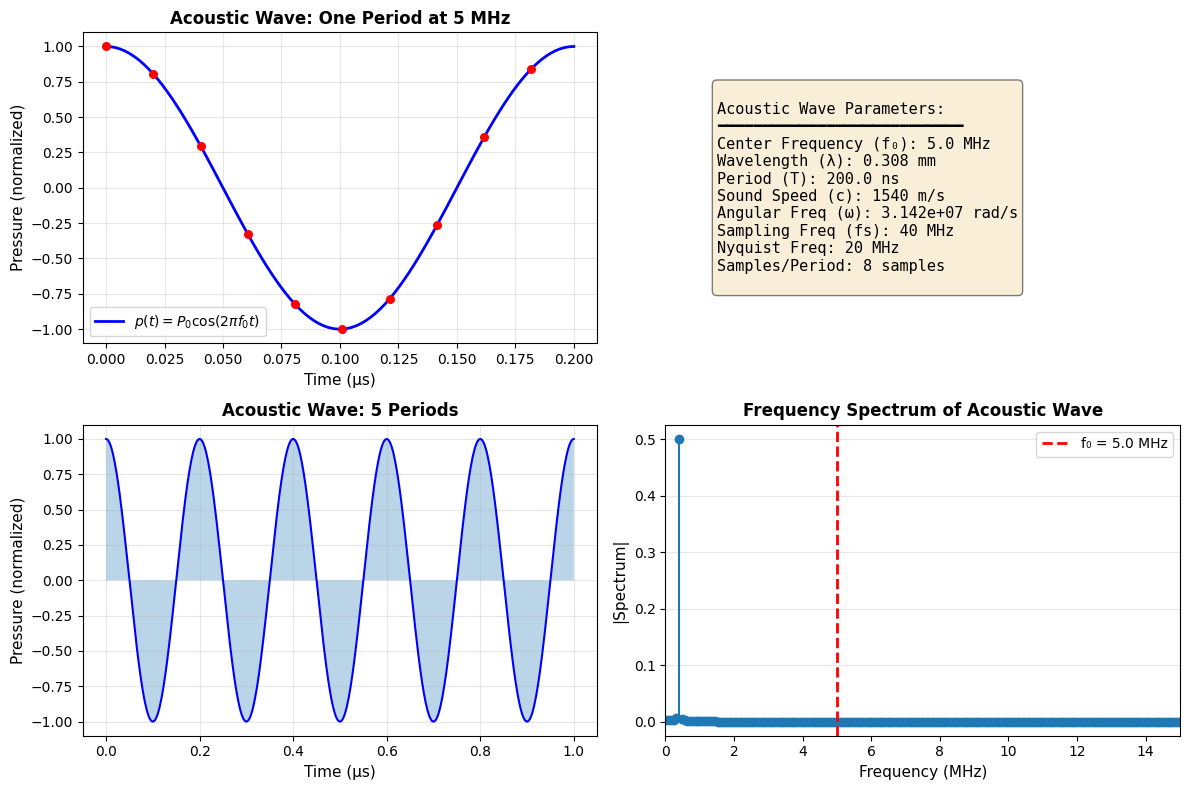

✓ Acoustic wavelength: 0.308 mm
✓ One period contains 8 samples at 40 MHz sampling rate


In [2]:
# Demonstration of Acoustic Wave Parameters
c = 1540  # sound speed [m/s]
f0 = 5e6  # center frequency [Hz]
fs = 40e6  # sampling frequency [Hz]

# Calculate derived parameters
wavelength = c / f0
period = 1 / f0
omega = 2 * np.pi * f0
nyquist_freq = fs / 2

# Time vector for one period
t_period = np.linspace(0, period, 100)

# Acoustic wave: p(t) = P0 * cos(2*pi*f0*t)
P0 = 1.0  # Normalized pressure amplitude
p_wave = P0 * np.cos(2 * np.pi * f0 * t_period)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: Pressure waveform
ax = axes[0, 0]
ax.plot(t_period * 1e6, p_wave, 'b-', linewidth=2, label='$p(t) = P_0 \cos(2\pi f_0 t)$')
ax.scatter(t_period[::10] * 1e6, p_wave[::10], color='red', s=30, zorder=5)
ax.grid(True, alpha=0.3)
ax.set_xlabel('Time (μs)', fontsize=11)
ax.set_ylabel('Pressure (normalized)', fontsize=11)
ax.set_title('Acoustic Wave: One Period at 5 MHz', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)

# Plot 2: Wave parameters
ax = axes[0, 1]
params_text = f"""
Acoustic Wave Parameters:
━━━━━━━━━━━━━━━━━━━━━━━━━━━
Center Frequency (f₀): {f0/1e6:.1f} MHz
Wavelength (λ): {wavelength*1e3:.3f} mm
Period (T): {period*1e9:.1f} ns
Sound Speed (c): {c} m/s
Angular Freq (ω): {omega:.3e} rad/s
Sampling Freq (fs): {fs/1e6:.0f} MHz
Nyquist Freq: {nyquist_freq/1e6:.0f} MHz
Samples/Period: {fs/f0:.0f} samples
"""
ax.text(0.1, 0.5, params_text, fontsize=11, family='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.axis('off')

# Plot 3: Multiple periods
t_multi = np.linspace(0, 5*period, 500)
p_multi = P0 * np.cos(2 * np.pi * f0 * t_multi)
ax = axes[1, 0]
ax.plot(t_multi * 1e6, p_multi, 'b-', linewidth=1.5)
ax.fill_between(t_multi * 1e6, p_multi, alpha=0.3)
ax.grid(True, alpha=0.3)
ax.set_xlabel('Time (μs)', fontsize=11)
ax.set_ylabel('Pressure (normalized)', fontsize=11)
ax.set_title('Acoustic Wave: 5 Periods', fontsize=12, fontweight='bold')

# Plot 4: Frequency spectrum
freq_spectrum = np.fft.fftfreq(len(p_multi), 1/fs)
spec = np.abs(np.fft.fft(p_multi)) / len(p_multi)
valid_freq = freq_spectrum[:len(freq_spectrum)//2]
valid_spec = spec[:len(spec)//2]
ax = axes[1, 1]
ax.stem(valid_freq/1e6, valid_spec, basefmt=' ')
ax.axvline(f0/1e6, color='red', linestyle='--', linewidth=2, label=f'f₀ = {f0/1e6:.1f} MHz')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xlabel('Frequency (MHz)', fontsize=11)
ax.set_ylabel('|Spectrum|', fontsize=11)
ax.set_title('Frequency Spectrum of Acoustic Wave', fontsize=12, fontweight='bold')
ax.set_xlim(0, 15)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"✓ Acoustic wavelength: {wavelength*1e3:.3f} mm")
print(f"✓ One period contains {fs/f0:.0f} samples at {fs/1e6:.0f} MHz sampling rate")

## 2. Frequency Domain Simulation Theory

### 2.1 Fourier Transform Fundamentals

The **Fourier Transform** converts time-domain signals to frequency domain:

$$X(f) = \int_{-\infty}^{\infty} x(t) e^{-j2\pi ft} dt$$

**Inverse Fourier Transform** recovers time domain:

$$x(t) = \int_{-\infty}^{\infty} X(f) e^{j2\pi ft} df$$

For digital signals (Discrete Fourier Transform - DFT):

$$X[k] = \sum_{n=0}^{N-1} x[n] e^{-j2\pi kn/N}$$

### 2.2 Real FFT (RFFT) for Real Signals

For real-valued signals, we use **Real FFT (RFFT)** which exploits conjugate symmetry:

$$X[k] = X^*[N-k] \quad \text{for real signals}$$

Benefits:
- **Memory**: ~50% reduction (only positive frequencies)
- **Speed**: ~2× faster than full FFT
- **Output**: $N/2 + 1$ complex values for N real samples

### 2.3 Scatterer Response in Frequency Domain

The response from a single scatterer at distance $d$ with magnitude $A$ is:

$$S(f) = A \cdot T(f) \cdot e^{-j2\pi f \tau} \cdot D_{tx}(f) \cdot D_{rx}(f)$$

Where:
- $T(f)$ = transmit waveform spectrum
- $\tau = 2d/c$ = round-trip travel time
- $D_{tx}(f)$, $D_{rx}(f)$ = transmit/receive directivity (frequency and angle dependent)

### 2.4 Total RF Data (Multiple Scatterers)

$$\text{RF}(f) = \sum_{i=1}^{N_{scat}} \sum_{tx=1}^{N_{tx}} \sum_{rx=1}^{N_{el}} S_i^{tx,rx}(f)$$

This is then converted back to time domain via inverse RFFT.

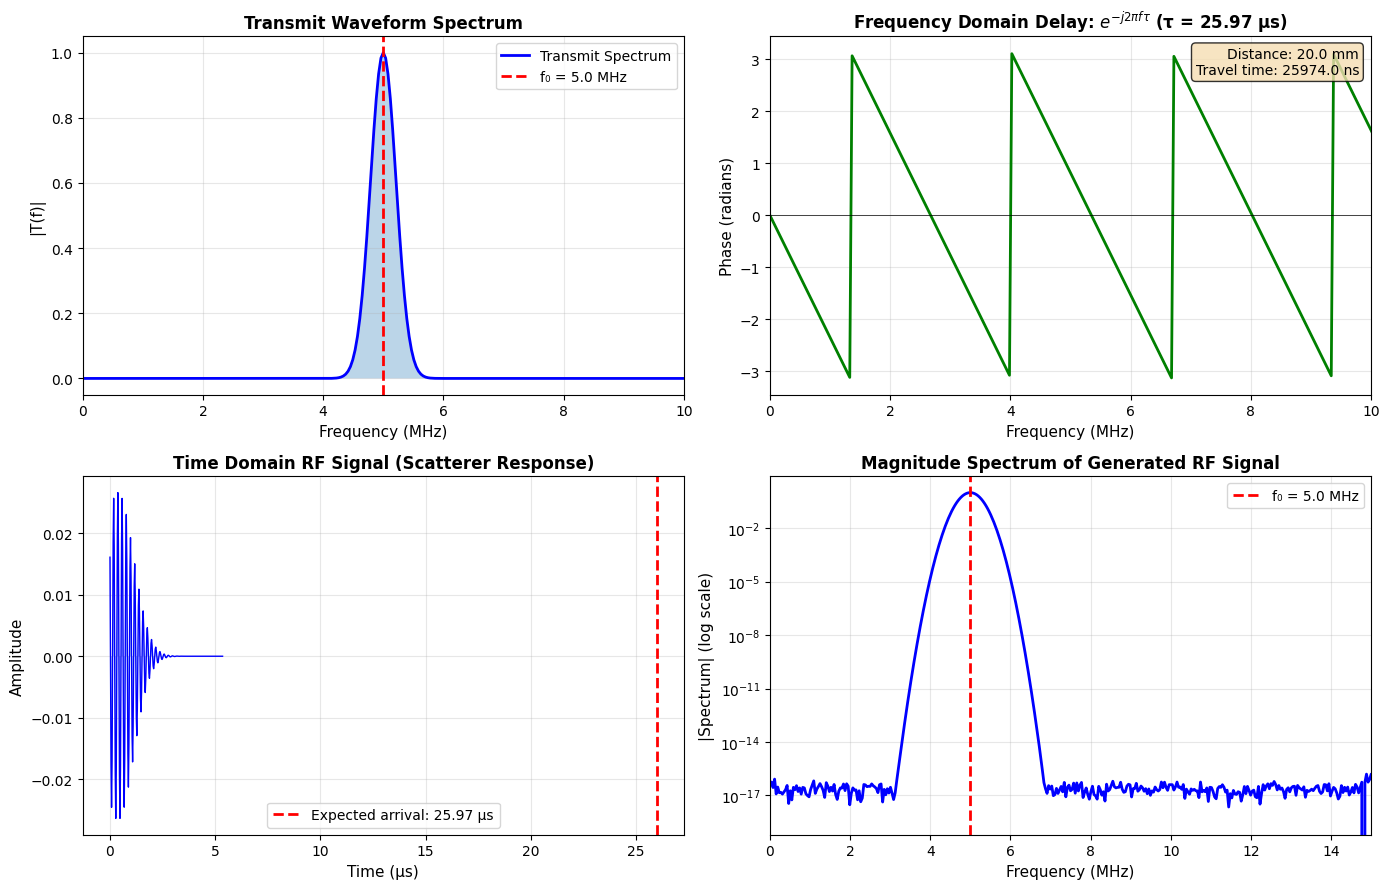

✓ Frequency Domain Simulation:
  - Scatterer depth: 20.0 mm
  - Round-trip travel time: 25974.0 ns
  - Signal peak amplitude: 0.0266
  - Signal peak at sample: 15 (time: 0.38 μs)


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_samples = 1024
fs = 40e6
c = 1540
f0 = 5e6

# Frequency vector (positive frequencies for RFFT)
freqs = np.fft.rfftfreq(n_samples, 1/fs)

# Transmit waveform: Gaussian-modulated pulse
def gaussian_pulse(f, f0, bw):
    """Gaussian pulse spectrum centered at f0 with bandwidth bw"""
    sigma = bw / (4*np.sqrt(2*np.log(2)))  # convert FWHM to std dev
    return np.exp(-(f - f0)**2 / (2 * sigma**2))

# Scatterer parameters
scatterer_distance = 20e-3  # 20 mm depth
scatterer_magnitude = 1.0
bandwidth = 1e6  # 1 MHz bandwidth
tx_freq = f0
rx_freq = f0

# Calculate travel time (round trip)
travel_time = 2 * scatterer_distance / c

# Transmit spectrum
T_f = gaussian_pulse(freqs, tx_freq, bandwidth)

# Delay in frequency domain: e^(-j*2*pi*f*tau)
delay_phase = np.exp(-1j * 2 * np.pi * freqs * travel_time)

# Receive directivity (simplified: unity response at normal incidence)
D_rx = np.ones_like(freqs)

# Scatterer response in frequency domain
S_f = scatterer_magnitude * T_f * delay_phase * D_rx

# Convert back to time domain
rf_signal = np.fft.irfft(S_f, n=n_samples)

# Time vector
t = np.arange(n_samples) / fs

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Plot 1: Transmit Spectrum
ax = axes[0, 0]
ax.plot(freqs/1e6, T_f, 'b-', linewidth=2, label='Transmit Spectrum')
ax.fill_between(freqs/1e6, T_f, alpha=0.3)
ax.axvline(f0/1e6, color='red', linestyle='--', linewidth=2, label=f'f₀ = {f0/1e6} MHz')
ax.set_xlabel('Frequency (MHz)', fontsize=11)
ax.set_ylabel('|T(f)|', fontsize=11)
ax.set_title('Transmit Waveform Spectrum', fontsize=12, fontweight='bold')
ax.set_xlim(0, 10)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Plot 2: Phase Delay
ax = axes[0, 1]
phase = np.angle(delay_phase)
ax.plot(freqs/1e6, phase, 'g-', linewidth=2)
ax.axhline(0, color='k', linestyle='-', linewidth=0.5)
ax.set_xlabel('Frequency (MHz)', fontsize=11)
ax.set_ylabel('Phase (radians)', fontsize=11)
ax.set_title(f'Frequency Domain Delay: $e^{{-j2\\pi f \\tau}}$ (τ = {travel_time*1e6:.2f} μs)',
             fontsize=12, fontweight='bold')
ax.set_xlim(0, 10)
ax.grid(True, alpha=0.3)
text_str = f"Distance: {scatterer_distance*1e3:.1f} mm\nTravel time: {travel_time*1e9:.1f} ns"
ax.text(0.98, 0.97, text_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 3: Time Domain RF Signal
ax = axes[1, 0]
peak_idx = np.argmax(np.abs(rf_signal))
plot_range = slice(max(0, peak_idx-200), min(len(t), peak_idx+200))
ax.plot(t[plot_range]*1e6, rf_signal[plot_range], 'b-', linewidth=1)
ax.axvline(travel_time*1e6, color='red', linestyle='--', linewidth=2,
           label=f'Expected arrival: {travel_time*1e6:.2f} μs')
ax.fill_between(t[plot_range]*1e6, rf_signal[plot_range], alpha=0.3)
ax.set_xlabel('Time (μs)', fontsize=11)
ax.set_ylabel('Amplitude', fontsize=11)
ax.set_title('Time Domain RF Signal (Scatterer Response)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Plot 4: Magnitude Spectrum of RF Signal
ax = axes[1, 1]
rf_spectrum = np.abs(np.fft.rfft(rf_signal))
ax.semilogy(freqs/1e6, rf_spectrum, 'b-', linewidth=2)
ax.axvline(f0/1e6, color='red', linestyle='--', linewidth=2, label=f'f₀ = {f0/1e6} MHz')
ax.set_xlabel('Frequency (MHz)', fontsize=11)
ax.set_ylabel('|Spectrum| (log scale)', fontsize=11)
ax.set_title('Magnitude Spectrum of Generated RF Signal', fontsize=12, fontweight='bold')
ax.set_xlim(0, 15)
ax.grid(True, alpha=0.3, which='both')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Frequency Domain Simulation:")
print(f"  - Scatterer depth: {scatterer_distance*1e3:.1f} mm")
print(f"  - Round-trip travel time: {travel_time*1e9:.1f} ns")
print(f"  - Signal peak amplitude: {np.max(np.abs(rf_signal)):.4f}")
print(f"  - Signal peak at sample: {peak_idx} (time: {t[peak_idx]*1e6:.2f} μs)")

## 3. Beamforming Mathematics

### 3.1 Delay-and-Sum (DAS) Beamforming

**Principle**: Focus ultrasound by aligning signals from multiple elements via delays.

For a transmit event focusing at angle $\theta$ and depth $z_f$:

$$y(t) = \frac{1}{N_{el}} \sum_{e=0}^{N_{el}-1} x_e(t - \tau_e(\theta, z_f))$$

Where:
- $x_e(t)$ = signal from element $e$
- $\tau_e$ = delay applied to element $e$
- $N_{el}$ = number of elements

### 3.2 Geometric Delay Calculation

For a linear array with element positions $x_e$ and focus point at $(x_f, z_f)$:

$$\tau_e = \frac{\sqrt{(x_e - x_f)^2 + z_f^2}}{c} - \frac{\sqrt{(x_0 - x_f)^2 + z_f^2}}{c}$$

Where $x_0$ is the reference element and $c$ is sound speed.

### 3.3 Planewave Beamforming

For a plane wave at angle $\theta$:

$$\tau_e = \frac{x_e \sin(\theta)}{c}$$

### 3.4 Beamforming Gain

**Coherent summation** of $N_{el}$ aligned signals:
- **SNR improvement**: $20 \log_{10}(N_{el})$ dB
- **Example**: 128 elements → 42.1 dB SNR improvement

**Incoherent noise** adds as:
$$\text{Noise}_{\text{sum}} = \sqrt{N_{el}} \cdot \text{Noise}_{\text{element}}$$

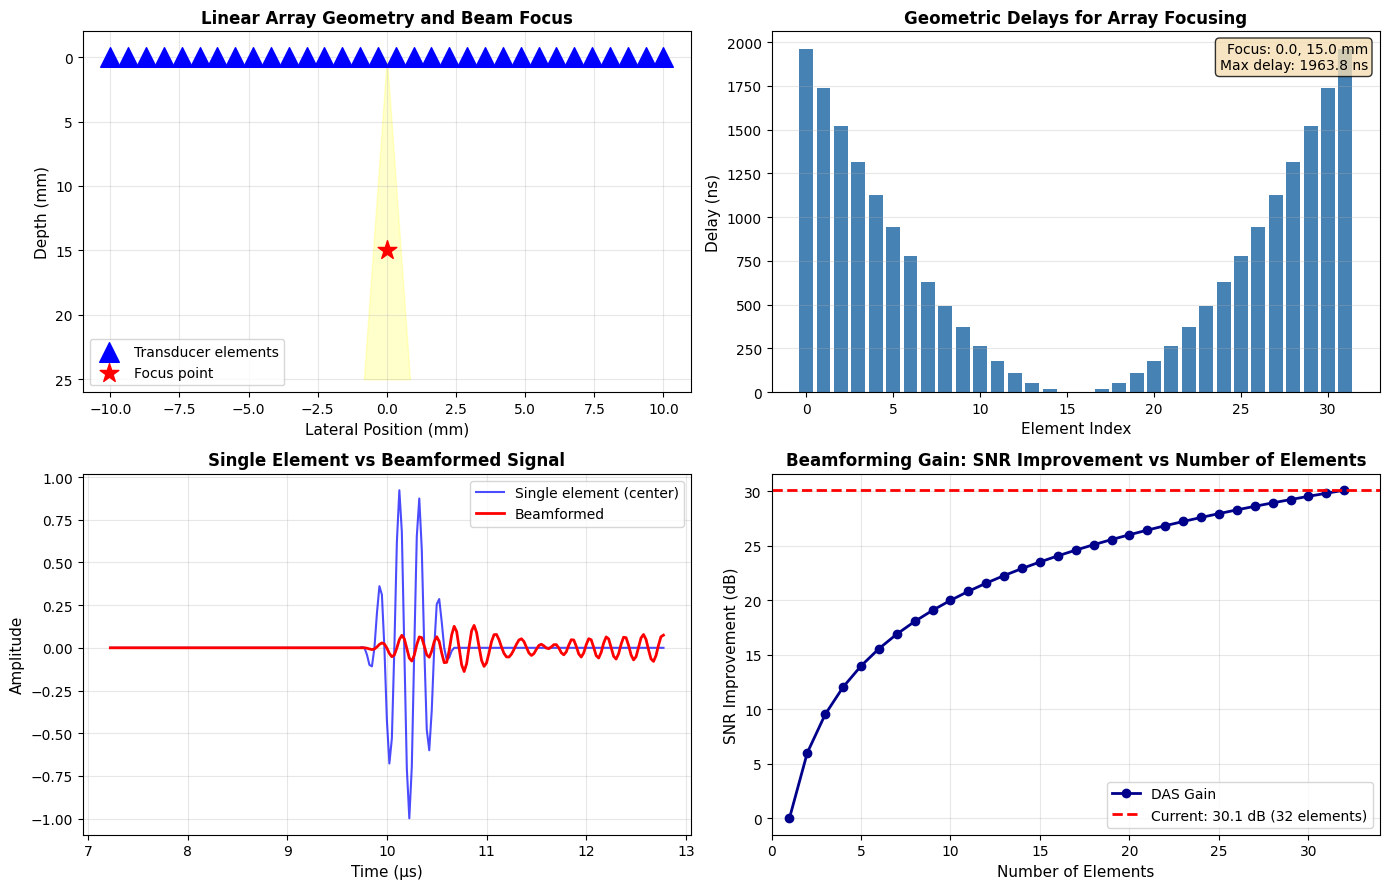

✓ Beamforming Demonstration:
  - Array: 32 elements, 20.0 mm aperture
  - Focus depth: 15.0 mm
  - Max geometric delay: 1963.82 ns
  - Travel time to focus: 9740.26 ns
  - SNR improvement (DAS gain): 30.1 dB


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Setup: Linear array with 32 elements focusing on a point scatterer
n_elements = 32
aperture = 20e-3  # 20 mm aperture
c = 1540

# Element positions
element_x = np.linspace(-aperture/2, aperture/2, n_elements)
element_z = np.zeros(n_elements)

# Focus point
focus_point = np.array([0, 0, 15e-3])  # 15 mm depth, center

# Calculate geometric delays (receive focusing)
distances = np.sqrt((element_x - focus_point[0])**2 + focus_point[2]**2)
reference_distance = distances[n_elements//2]  # Reference from center element
geometric_delays = (distances - reference_distance) / c

# Signal parameters
n_samples = 512
fs = 40e6
t = np.arange(n_samples) / fs
f0 = 5e6

# Travel time (one-way to focus)
travel_time = focus_point[2] / c

# Generate synthetic RF signals (short burst at focus time)
pulse_cycles = 5
pulse_len = int(pulse_cycles * fs / f0)
window = np.hanning(pulse_len)
pulse = np.cos(2*np.pi*f0*t[:pulse_len]) * window

signals = np.zeros((n_elements, n_samples))
for e in range(n_elements):
    delay = travel_time + geometric_delays[e]
    center = int(delay * fs)
    if center + pulse_len < n_samples:
        signals[e, center:center+pulse_len] = pulse

# Beamform with fractional delays (frequency-domain phase shift)
freqs = np.fft.rfftfreq(n_samples, 1/fs)
beamformed_signal = np.zeros(n_samples)
for e in range(n_elements):
    spectrum = np.fft.rfft(signals[e])
    phase_shift = np.exp(-1j*2*np.pi*freqs*geometric_delays[e])
    shifted = np.fft.irfft(spectrum * phase_shift, n=n_samples)
    beamformed_signal += shifted
beamformed_signal /= n_elements

# Single element signal for comparison
single_element = signals[n_elements//2, :]

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Plot 1: Array geometry and focus point
ax = axes[0, 0]
ax.scatter(element_x*1e3, element_z*1e3, s=200, c='blue', marker='^', label='Transducer elements', zorder=5)
ax.scatter(focus_point[0]*1e3, focus_point[2]*1e3, s=200, c='red', marker='*', label='Focus point', zorder=5)
beam_depth = np.linspace(0, 25e-3, 50)
beam_width = 0.5e-3 * beam_depth / focus_point[2]
ax.fill_betweenx(beam_depth*1e3, -beam_width*1e3, beam_width*1e3, alpha=0.2, color='yellow')
ax.set_xlabel('Lateral Position (mm)', fontsize=11)
ax.set_ylabel('Depth (mm)', fontsize=11)
ax.set_title('Linear Array Geometry and Beam Focus', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)
ax.set_ylim(-2, 26)
ax.invert_yaxis()

# Plot 2: Geometric delays
ax = axes[0, 1]
ax.bar(np.arange(n_elements), geometric_delays*1e9, color='steelblue', width=0.8)
ax.set_xlabel('Element Index', fontsize=11)
ax.set_ylabel('Delay (ns)', fontsize=11)
ax.set_title('Geometric Delays for Array Focusing', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0, color='k', linestyle='-', linewidth=0.5)
text_str = f"Focus: {focus_point[0]*1e3:.1f}, {focus_point[2]*1e3:.1f} mm\n" \
           f"Max delay: {np.max(geometric_delays)*1e9:.1f} ns"
ax.text(0.98, 0.97, text_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 3: Single element vs beamformed signal
ax = axes[1, 0]
plot_idx = slice(int(travel_time*fs - 100), int(travel_time*fs + 200))
ax.plot(t[plot_idx]*1e6, single_element[plot_idx], 'b-', linewidth=1.5, label='Single element (center)', alpha=0.7)
ax.plot(t[plot_idx]*1e6, beamformed_signal[plot_idx], 'r-', linewidth=2, label='Beamformed')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Time (μs)', fontsize=11)
ax.set_ylabel('Amplitude', fontsize=11)
ax.set_title('Single Element vs Beamformed Signal', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)

# Plot 4: SNR improvement
ax = axes[1, 1]
n_elements_range = np.arange(1, n_elements+1)
das_gain_db = 20 * np.log10(n_elements_range)
ax.plot(n_elements_range, das_gain_db, 'o-', linewidth=2, markersize=6, color='darkblue', label='DAS Gain')
ax.axhline(20*np.log10(n_elements), color='red', linestyle='--', linewidth=2,
           label=f'Current: {20*np.log10(n_elements):.1f} dB ({n_elements} elements)')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Number of Elements', fontsize=11)
ax.set_ylabel('SNR Improvement (dB)', fontsize=11)
ax.set_title('Beamforming Gain: SNR Improvement vs Number of Elements', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.set_xlim(0, n_elements+2)

plt.tight_layout()
plt.show()

print("✓ Beamforming Demonstration:")
print(f"  - Array: {n_elements} elements, {aperture*1e3:.1f} mm aperture")
print(f"  - Focus depth: {focus_point[2]*1e3:.1f} mm")
print(f"  - Max geometric delay: {np.max(geometric_delays)*1e9:.2f} ns")
print(f"  - Travel time to focus: {travel_time*1e9:.2f} ns")
print(f"  - SNR improvement (DAS gain): {20*np.log10(n_elements):.1f} dB")

## 4. Scattering and Attenuation Physics

### 4.1 Rayleigh Scattering

For scatterers much smaller than wavelength ($d \ll \lambda$):

$$\sigma_{\text{Rayleigh}} = \frac{k^4 V^2}{12\pi} \quad \text{where} \quad k = 2\pi/\lambda$$

**Key property**: Scattering power ∝ $f^4$ (strong frequency dependence)

### 4.2 Geometrical Spreading Loss

As acoustic wave propagates from point source:

$$p(r, t) = \frac{A}{r} \cos(kr - \omega t)$$

Power per unit area (Intensity):

$$I(r) = \frac{I_0}{r^2} \quad \text{(spherical spreading)}$$

In dB: $\text{Spreading Loss} = 20 \log_{10}(r) + \text{const}$

### 4.3 Frequency-Dependent Attenuation

Acoustic waves attenuate exponentially:

$$p(x, f) = p_0(f) \cdot e^{-\alpha(f) x}$$

Where attenuation coefficient:

$$\alpha(f) = 0.689 \times \text{attenuation\_coef} \times f$$

**Units**: attenuation_coef in dB/cm/MHz, $\alpha$ in Nepers/meter

In dB scale (round trip):

$$\text{Attenuation}_{dB} = 2 \times 20 \times \alpha(f) \times d / \log(10)$$

### 4.4 Complete Signal Propagation Model

Received signal from scatterer at distance $d$ with magnitude $A$:

$$s(t) = A \cdot e^{-\alpha(f_0) d} \cdot \frac{1}{d^2} \cdot D_{tx}(\theta) \cdot D_{rx}(\theta) \cdot p_{tx}(t - 2d/c)$$

Where losses are:
- **Attenuation**: $e^{-\alpha(f) d}$ 
- **Spreading**: $1/d^2$
- **Directivity**: $D_{tx} \times D_{rx}$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


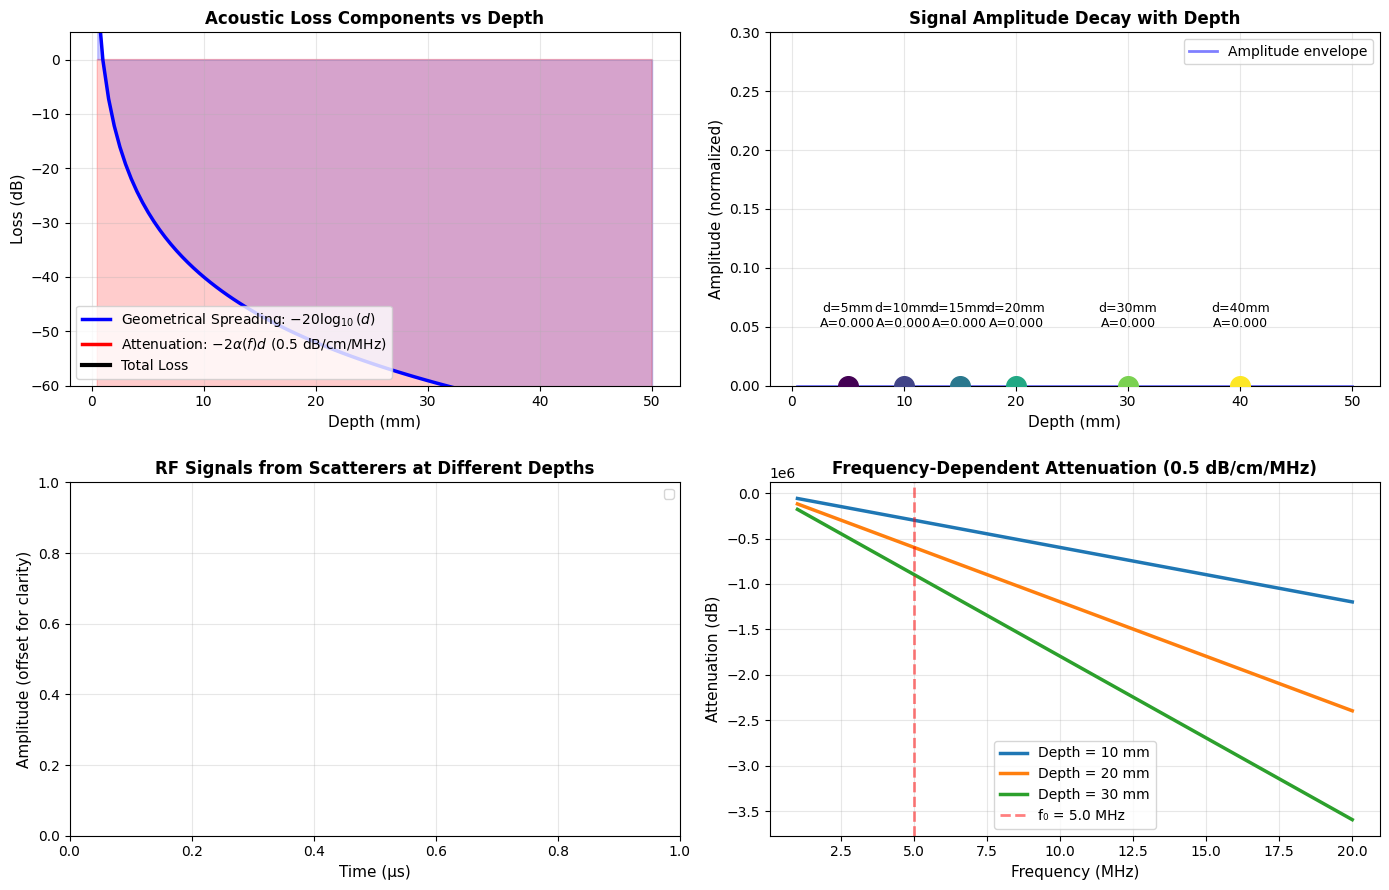

✓ Attenuation and Scattering Analysis:
  - Center frequency: 5.0 MHz
  - Attenuation coefficient: 0.5 dB/cm/MHz
  - α(f₀) = 1722500.00 Nepers/m = 14961444.90 dB/m

  Loss at different depths:
  Depth (mm)   Spreading (dB)     Attenuation (dB)     Total (dB)  
  ------------------------------------------------------------
  5            -28.13             -151125.71           -151153.84  
  10           -40.17             -302251.41           -302291.59  
  15           -47.22             -453377.12           -453424.34  
  20           -52.22             -604502.82           -604555.04  
  30           -58.97             -891641.67           -891700.63  
  40           -64.04             -1193893.08          -1193957.12 


In [12]:
# Scattering and Attenuation Demonstration

c = 1540  # sound speed
f0 = 5e6  # center frequency
attenuation_coef = 0.5  # dB/cm/MHz

# Depth range
depths = np.linspace(0, 50e-3, 100)  # 0-50 mm

# Calculate losses as functions of depth

# 1. Geometrical spreading loss: 1/d^2
spreading_loss_linear = 1 / (depths[1:] / 1e-3)**2  # normalized
spreading_loss_db = 20 * np.log10(spreading_loss_linear)

# 2. Frequency-dependent attenuation
# α(f) = 0.689 × coef × f [Nepers/m]
alpha_coef = 0.689 * attenuation_coef * f0  # [Nepers/m]
# Round-trip attenuation: 2 * alpha * d
attenuation_roundtrip_nepers = 2 * alpha_coef * depths[1:]  # [Nepers]
attenuation_db = -20 / np.log(10) * attenuation_roundtrip_nepers  # Convert to dB

# 3. Total loss
total_loss_db = spreading_loss_db + attenuation_db

# 4. Signal amplitude with losses
reference_amplitude = 1.0
signal_amplitude = reference_amplitude / (depths[1:] / 1e-3) * np.exp(-alpha_coef * depths[1:])

# Create scatterers at different depths
scatterer_depths = np.array([5, 10, 15, 20, 30, 40])  # mm
colors = plt.cm.viridis(np.linspace(0, 1, len(scatterer_depths)))

fig, axes = plt.subplots(2, 2, figsize=(14, 9))

# Plot 1: Individual loss components
ax = axes[0, 0]
ax.plot(depths[1:]*1e3, spreading_loss_db, 'b-', linewidth=2.5, label='Geometrical Spreading: $-20\\log_{10}(d)$')
ax.plot(depths[1:]*1e3, attenuation_db, 'r-', linewidth=2.5, label=f'Attenuation: $-2\\alpha(f)d$ ({attenuation_coef} dB/cm/MHz)')
ax.plot(depths[1:]*1e3, total_loss_db, 'k-', linewidth=3, label='Total Loss')
ax.fill_between(depths[1:]*1e3, spreading_loss_db, alpha=0.2, color='blue')
ax.fill_between(depths[1:]*1e3, attenuation_db, alpha=0.2, color='red')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Depth (mm)', fontsize=11)
ax.set_ylabel('Loss (dB)', fontsize=11)
ax.set_title('Acoustic Loss Components vs Depth', fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='lower left')
ax.set_ylim(-60, 5)

# Plot 2: Signal amplitude with depth
ax = axes[0, 1]
for i, d in enumerate(scatterer_depths):
    idx = np.argmin(np.abs(depths - d*1e-3))
    amp = signal_amplitude[max(0, idx-1)]
    ax.scatter(d, amp, s=200, c=[colors[i]], marker='o', zorder=5)
    ax.text(d, amp+0.05, f'd={d}mm\nA={amp:.3f}', ha='center', fontsize=9)

ax.plot(depths[1:]*1e3, signal_amplitude, 'b-', linewidth=2, alpha=0.5, label='Amplitude envelope')
ax.fill_between(depths[1:]*1e3, signal_amplitude, alpha=0.2, color='blue')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Depth (mm)', fontsize=11)
ax.set_ylabel('Amplitude (normalized)', fontsize=11)
ax.set_title('Signal Amplitude Decay with Depth', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.set_ylim(0, 0.3)

# Plot 3: RF signals at different depths
ax = axes[1, 0]
fs = 40e6
n_samples = 256
t = np.arange(n_samples) / fs

for i, d in enumerate(scatterer_depths):
    # Travel time
    tau = 2 * d * 1e-3 / c
    arrival_sample = int(tau * fs)
    
    if 0 <= arrival_sample < n_samples:
        # Signal with amplitude decay
        idx_depth = np.argmin(np.abs(depths - d*1e-3))
        amplitude = signal_amplitude[max(0, idx_depth-1)]
        
        # RF signal
        signal_t = amplitude * np.cos(2 * np.pi * f0 * (t - tau))
        window = np.hanning(50)
        windowed_signal = signal_t.copy()
        if arrival_sample+len(window)//2 < n_samples:
            windowed_signal[arrival_sample-len(window)//2:arrival_sample+len(window)//2] *= window
        
        ax.plot(t*1e6, windowed_signal + i*0.15, color=colors[i], linewidth=1.5, label=f'd={d}mm')

ax.set_xlabel('Time (μs)', fontsize=11)
ax.set_ylabel('Amplitude (offset for clarity)', fontsize=11)
ax.set_title('RF Signals from Scatterers at Different Depths', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9, loc='upper right', ncol=2)

# Plot 4: Frequency-dependent attenuation
ax = axes[1, 1]
frequencies = np.linspace(1e6, 20e6, 100)
depths_plot = [10, 20, 30]  # mm
for d_mm in depths_plot:
    d = d_mm * 1e-3
    alpha_f = 0.689 * attenuation_coef * frequencies
    atten = -20 / np.log(10) * 2 * alpha_f * d
    ax.plot(frequencies/1e6, atten, linewidth=2.5, label=f'Depth = {d_mm} mm')

ax.axvline(f0/1e6, color='red', linestyle='--', linewidth=2, alpha=0.5, label=f'f₀ = {f0/1e6} MHz')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Frequency (MHz)', fontsize=11)
ax.set_ylabel('Attenuation (dB)', fontsize=11)
ax.set_title(f'Frequency-Dependent Attenuation ({attenuation_coef} dB/cm/MHz)', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Quantitative analysis
print("✓ Attenuation and Scattering Analysis:")
print(f"  - Center frequency: {f0/1e6:.1f} MHz")
print(f"  - Attenuation coefficient: {attenuation_coef} dB/cm/MHz")
print(f"  - α(f₀) = {alpha_coef:.2f} Nepers/m = {alpha_coef*20/np.log(10):.2f} dB/m")
print(f"\n  Loss at different depths:")
print(f"  {'Depth (mm)':<12} {'Spreading (dB)':<18} {'Attenuation (dB)':<20} {'Total (dB)':<12}")
print(f"  {'-'*60}")
for d_mm in scatterer_depths:
    d_m = d_mm * 1e-3
    idx = np.argmin(np.abs(depths - d_m))
    spread_db = spreading_loss_db[max(0, idx-1)]
    atten_db = attenuation_db[max(0, idx-1)]
    total_db = total_loss_db[max(0, idx-1)]
    print(f"  {d_mm:<12} {spread_db:<18.2f} {atten_db:<20.2f} {total_db:<12.2f}")

## 5. Envelope Detection and Log Compression

### 5.1 Analytic Signal and Envelope

Given a narrowband RF signal $x(t) = a(t) \cos(\omega_0 t + \phi(t))$, the **analytic signal** is:

$$z(t) = x(t) + j\mathcal{H}[x(t)]$$

Where $\mathcal{H}[x(t)]$ is the **Hilbert transform** (90° phase shift).

The **envelope** or **amplitude modulation** is:

$$a(t) = |z(t)| = \sqrt{x(t)^2 + \mathcal{H}[x(t)]^2}$$

### 5.2 Log Compression (Decibel Scale)

Logarithmic compression matches human perception:

$$L(t) = 20 \log_{10}\left(\frac{a(t)}{a_{\text{max}}} + \epsilon\right)$$

Where:
- $a_{\text{max}}$ = maximum envelope amplitude
- $\epsilon = 10^{-6}$ = small offset to prevent $\log(0)$
- Result is in dB scale (0 to -∞ dB)

### 5.3 Dynamic Range

Linear amplitude range $[0, 1]$ maps to:
- Logarithmic range: $[-\infty, 0]$ dB
- Practical range (clipped at -60 dB): $[-60, 0]$ dB
- Dynamic range: $60$ dB = $1,000,000:1$ amplitude ratio

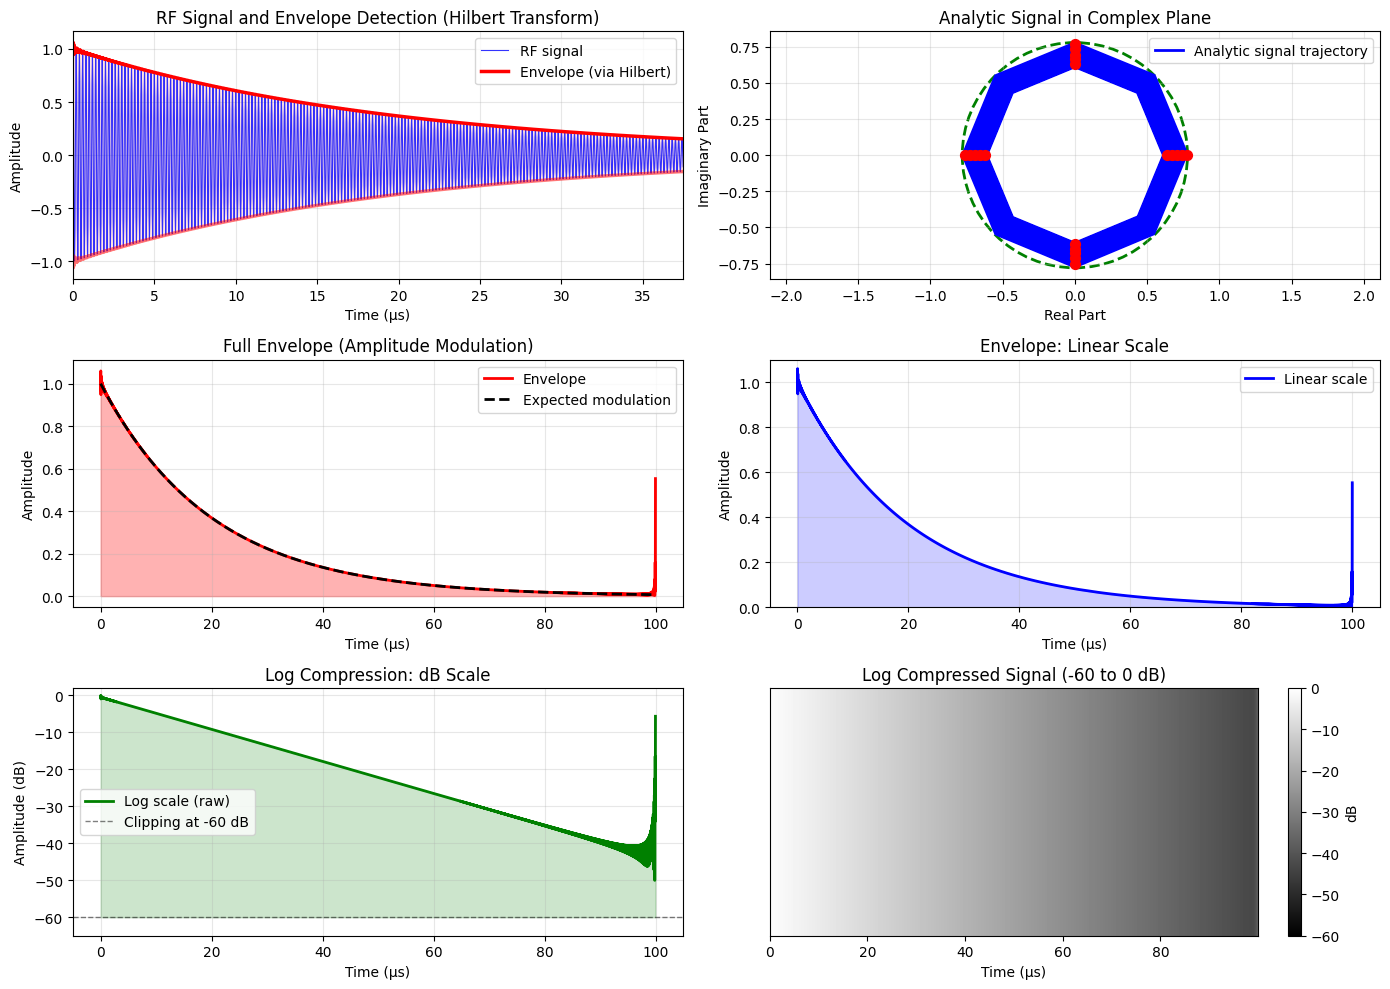

✓ Envelope Detection and Log Compression:
  - RF signal properties:
    • Carrier frequency: 5.0 MHz
    • Duration: 100.0 μs
    • Number of samples: 4000

  - Envelope properties:
    • Maximum amplitude: 1.0601
    • Minimum amplitude: 3.3418e-03
    • Dynamic range (linear): 317:1

  - Log compression (dB scale):
    • Maximum: 0.00 dB
    • Minimum (raw): -50.02 dB
    • Clipped range: -60 to 0 dB
    • Dynamic range (60 dB): 1,000,000:1


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert   # <-- import Hilbert transform

# Create a synthetic RF signal with amplitude modulation
fs = 40e6
f0 = 5e6
t = np.arange(4000) / fs  # ~100 μs

# Chirp signal with time-varying amplitude (simulating depth variation)
depth_variation = np.exp(-5 * t / t[-1])  # Exponential decay
amplitude_modulation = depth_variation * (1 + 0.3 * np.sin(2 * np.pi * 50 * t))

# RF signal: modulated narrow-band signal
rf_signal = amplitude_modulation * np.cos(2 * np.pi * f0 * t)

# 1. Envelope detection using Hilbert transform
analytic_signal = hilbert(rf_signal)
envelope = np.abs(analytic_signal)

# 2. Log compression
log_envelope_raw = 20 * np.log10(envelope / np.max(envelope) + 1e-6)
# Clip to -60 dB for visualization
log_envelope_clipped = np.clip(log_envelope_raw, -60, 0)

# Visualization
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Plot 1: Original RF signal
ax = axes[0, 0]
plot_idx = slice(0, 1500)  # First 37.5 μs
ax.plot(t[plot_idx]*1e6, rf_signal[plot_idx], 'b-', linewidth=0.8, label='RF signal', alpha=0.8)
ax.plot(t[plot_idx]*1e6, envelope[plot_idx], 'r-', linewidth=2.5, label='Envelope (via Hilbert)')
ax.plot(t[plot_idx]*1e6, -envelope[plot_idx], 'r-', linewidth=2.5, alpha=0.5)
ax.fill_between(t[plot_idx]*1e6, envelope[plot_idx], -envelope[plot_idx], alpha=0.1, color='red')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('RF Signal and Envelope Detection (Hilbert Transform)')
ax.legend()
ax.set_xlim(t[plot_idx][0]*1e6, t[plot_idx][-1]*1e6)

# Plot 2: Analytic signal (complex plane)
ax = axes[0, 1]
plot_idx2 = slice(200, 400)
ax.plot(np.real(analytic_signal[plot_idx2]), np.imag(analytic_signal[plot_idx2]),
        'b-', linewidth=2, label='Analytic signal trajectory')
ax.scatter(np.real(analytic_signal[plot_idx2][::10]),
           np.imag(analytic_signal[plot_idx2][::10]), s=50, c='red', zorder=5)
circle = plt.Circle((0, 0), np.max(envelope[plot_idx2]), fill=False,
                    color='green', linestyle='--', linewidth=2)
ax.add_patch(circle)
ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_title('Analytic Signal in Complex Plane')
ax.axis('equal')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 3: Envelope over full signal
ax = axes[1, 0]
ax.plot(t*1e6, envelope, 'r-', linewidth=2, label='Envelope')
ax.fill_between(t*1e6, envelope, alpha=0.3, color='red')
ax.plot(t*1e6, amplitude_modulation, 'k--', linewidth=2, label='Expected modulation')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Full Envelope (Amplitude Modulation)')
ax.legend()

# Plot 4: Linear scale comparison
ax = axes[1, 1]
ax.plot(t*1e6, envelope, 'b-', linewidth=2, label='Linear scale')
ax.fill_between(t*1e6, envelope, alpha=0.2, color='blue')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Envelope: Linear Scale')
ax.legend()
ax.set_ylim(0, 1.1)

# Plot 5: Log scale (dB)
ax = axes[2, 0]
ax.plot(t*1e6, log_envelope_raw, 'g-', linewidth=2, label='Log scale (raw)')
ax.axhline(-60, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Clipping at -60 dB')
ax.fill_between(t*1e6, log_envelope_raw, -60, alpha=0.2, color='green')
ax.grid(True, alpha=0.3)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title('Log Compression: dB Scale')
ax.legend()
ax.set_ylim(-65, 2)

# Plot 6: Clipped log scale (imshow expects 2D array)
ax = axes[2, 1]
im = ax.imshow(log_envelope_clipped[np.newaxis, :], aspect='auto', cmap='gray',
               extent=[t[0]*1e6, t[-1]*1e6, -1, 1], vmin=-60, vmax=0)
ax.set_xlabel('Time (μs)')
ax.set_title('Log Compressed Signal (-60 to 0 dB)')
ax.set_ylim(0.2, 0.8)
ax.set_yticks([])
cbar = plt.colorbar(im, ax=ax, label='dB')

plt.tight_layout()
plt.show()

# Analysis
print("✓ Envelope Detection and Log Compression:")
print(f"  - RF signal properties:")
print(f"    • Carrier frequency: {f0/1e6:.1f} MHz")
print(f"    • Duration: {t[-1]*1e6:.1f} μs")
print(f"    • Number of samples: {len(t)}")
print("\n  - Envelope properties:")
print(f"    • Maximum amplitude: {np.max(envelope):.4f}")
print(f"    • Minimum amplitude: {np.min(envelope):.4e}")
print(f"    • Dynamic range (linear): {np.max(envelope)/np.min(envelope[envelope>1e-8]):.0f}:1")
print("\n  - Log compression (dB scale):")
print(f"    • Maximum: {np.max(log_envelope_raw):.2f} dB")
print(f"    • Minimum (raw): {np.min(log_envelope_raw):.2f} dB")
print(f"    • Clipped range: -60 to 0 dB")
print(f"    • Dynamic range (60 dB): 1,000,000:1")

## 6. Complete Synthetic Data Generation Workflow

### 6.1 Workflow Steps

1. **Define Probe**: Transducer geometry and specifications
2. **Define Scan**: Transmit scheme (planewave, focused, etc.) and delays
3. **Define Phantom**: Scatterer positions and magnitudes
4. **Generate RF Data**: Using frequency domain simulation
5. **Process**: Beamform, envelope detect, log compress
6. **Visualize**: Display B-mode image

### 6.2 Mathematical Chain

$$\text{RF}(t) = \text{IFFT}\left\{\sum_{s,tx,rx} A_s \cdot T(f) \cdot e^{-j2\pi f \tau_{s,tx,rx}} \cdot D_{tx} \cdot D_{rx} \cdot \text{Atten} \cdot \text{Spread}\right\}$$

Then:
1. **Beamforming**: Sum with delays → $\text{Beamformed}(t) = \frac{1}{N_{el}} \sum_{el} \text{RF}(t - \tau_{el})$
2. **Envelope**: $a(t) = |\text{Hilbert}(\text{Beamformed})|$
3. **Log Compression**: $L(t) = 20\log_{10}(a(t)/a_{max} + \epsilon)$
4. **Display**: Image in dB scale

COMPLETE ULTRASOUND SYNTHETIC DATA GENERATION WORKFLOW (Fixed)

[1] PROBE DEFINITION
----------------------------------------------------------------------
Elements: 64, Aperture: 30.0 mm, f0: 5.0 MHz, fs: 40.0 MHz
Wavelength: 0.31 mm, Pitch: 0.48 mm

[2] SCAN DEFINITION (Planewave)
----------------------------------------------------------------------
Transmits: 5, angles (deg): [-15.   -7.5   0.    7.5  15. ]
Max TX delay: 2520.96 ns

[3] PHANTOM DEFINITION
----------------------------------------------------------------------
Scatterers: 64, depth 10.0–35.0 mm

[4] SCATTERER RF RESPONSE (time domain)
----------------------------------------------------------------------
RF data shape: (64, 4096), peak amp: 90.246

[5] BEAMFORMING (Delay-and-Sum)
----------------------------------------------------------------------
Beamformed max amplitude: 31.795

[6] ENVELOPE & LOG COMPRESSION
----------------------------------------------------------------------
Envelope max: 32.918, Log range: [

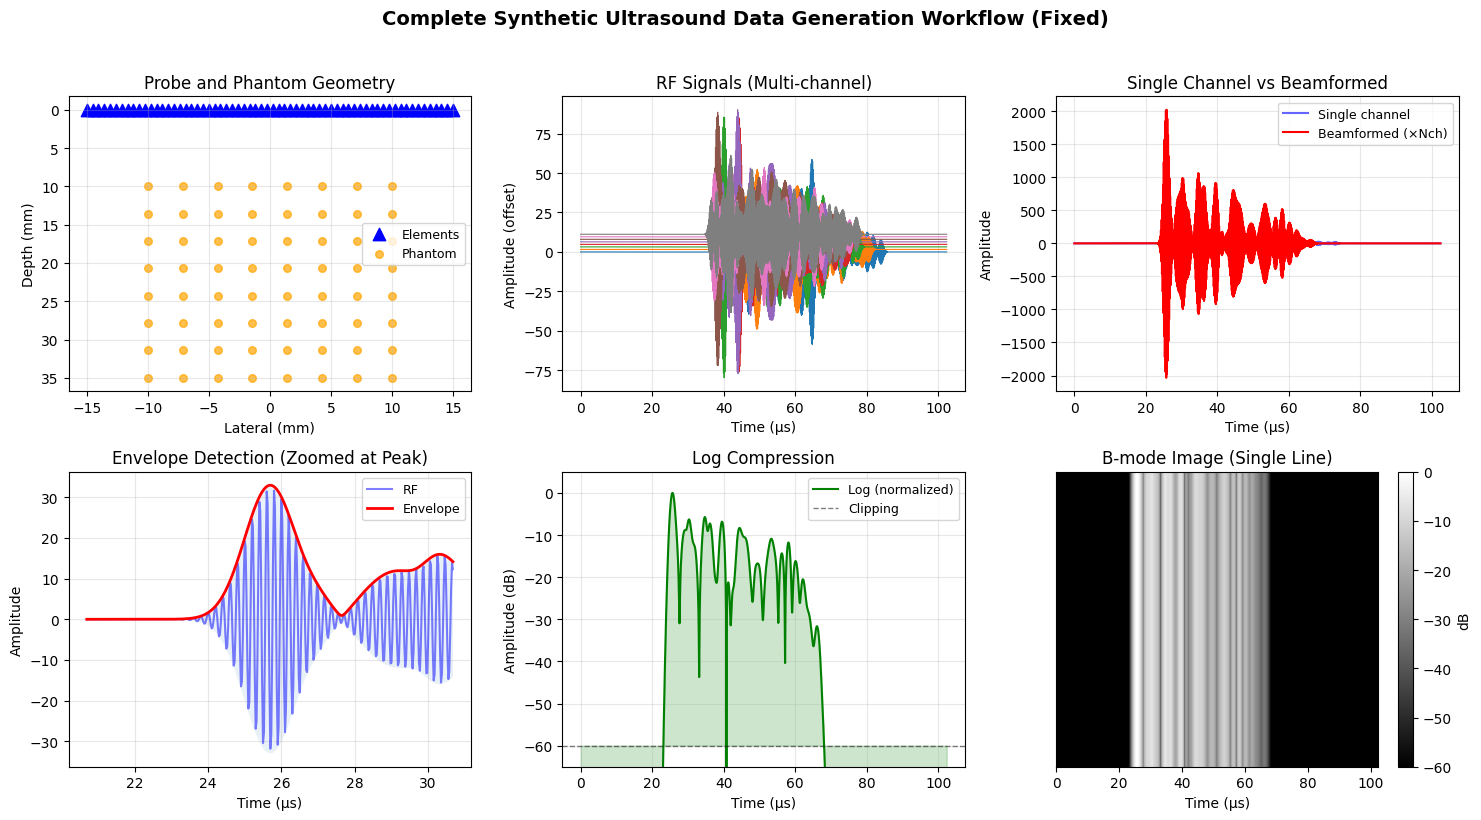


✓ Workflow completed successfully!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

print("=" * 70)
print("COMPLETE ULTRASOUND SYNTHETIC DATA GENERATION WORKFLOW (Fixed)")
print("=" * 70)

# -----------------------------------------------------------------------------
# [1] Probe and system
# -----------------------------------------------------------------------------
n_elements = 64
aperture = 30e-3
c = 1540.0
f0 = 5e6
fs = 40e6

element_positions = np.stack([
    np.linspace(-aperture/2, aperture/2, n_elements),
    np.zeros(n_elements),
    np.zeros(n_elements),
], axis=1)

print("\n[1] PROBE DEFINITION")
print("-" * 70)
print(f"Elements: {n_elements}, Aperture: {aperture*1e3:.1f} mm, f0: {f0/1e6:.1f} MHz, fs: {fs/1e6:.1f} MHz")
print(f"Wavelength: {c/f0*1e3:.2f} mm, Pitch: {aperture/(n_elements-1)*1e3:.2f} mm")

# -----------------------------------------------------------------------------
# [2] Transmit scan (plane waves)
# -----------------------------------------------------------------------------
n_transmit = 5
angles = np.linspace(-15, 15, n_transmit) * np.pi / 180.0
t0_delays = np.zeros((n_transmit, n_elements))
for tx in range(n_transmit):
    angle = angles[tx]
    t0_delays[tx, :] = element_positions[:, 0] * np.sin(angle) / c

print("\n[2] SCAN DEFINITION (Planewave)")
print("-" * 70)
print(f"Transmits: {n_transmit}, angles (deg): {angles*180/np.pi}")
print(f"Max TX delay: {np.max(np.abs(t0_delays))*1e9:.2f} ns")

# -----------------------------------------------------------------------------
# [3] Phantom
# -----------------------------------------------------------------------------
scat_x = np.linspace(-10e-3, 10e-3, 8)
scat_z = np.linspace(10e-3, 35e-3, 8)
scat_x_grid, scat_z_grid = np.meshgrid(scat_x, scat_z, indexing='ij')

scatterer_positions = np.column_stack([
    scat_x_grid.ravel(),
    np.zeros(scat_x_grid.size),
    scat_z_grid.ravel(),
]).astype(np.float32)

np.random.seed(42)
scatterer_magnitudes = np.random.uniform(0.6, 1.0, len(scatterer_positions)).astype(np.float32)  # boost magnitudes

print("\n[3] PHANTOM DEFINITION")
print("-" * 70)
print(f"Scatterers: {len(scatterer_positions)}, depth {scat_z[0]*1e3:.1f}–{scat_z[-1]*1e3:.1f} mm")

# -----------------------------------------------------------------------------
# [4] Baseband pulse (time domain)
# -----------------------------------------------------------------------------
# Use a Gaussian-modulated tone for controlled bandwidth and amplitude
def gaussian_tone(t, f0, bw_frac=0.6):
    # bw_frac controls pulse width ~ cycles; larger -> narrower pulse
    tau = 2.0 / (bw_frac * f0)  # pulse scale
    g = np.exp(-((t - t[-1]/4.0)**2) / (2 * tau**2))  # center early
    return g * np.cos(2*np.pi*f0*t)

n_ax = 4096  # extend axial window (4096/40MHz ~ 102.4 μs -> ~79 mm two-way)
t_ax = np.arange(n_ax) / fs
pulse = gaussian_tone(t_ax, f0, bw_frac=0.6)
pulse /= np.max(np.abs(pulse))  # normalize

# -----------------------------------------------------------------------------
# [5] RF synthesis for one transmit (time domain, per channel)
# -----------------------------------------------------------------------------
test_tx = 0
rf_time_data = np.zeros((n_elements, n_ax), dtype=np.float32)

# Simple attenuation model with moderate loss to keep signal visible
alpha_db_per_mhz_cm = 0.7  # typical soft tissue
alpha_np_per_m = alpha_db_per_mhz_cm * (f0/1e6) * 0.1151  # dB->Np approx per meter
def attenuation(z):
    return np.exp(-alpha_np_per_m * z)  # one-way

for el in range(n_elements):
    # Sum echoes from all scatterers
    acc = np.zeros(n_ax, dtype=np.float32)
    for pos, mag in zip(scatterer_positions, scatterer_magnitudes):
        r_tx = np.linalg.norm(element_positions[el] - pos)
        r_rx = r_tx  # monostatic approximation
        t_delay = (r_tx + r_rx) / c + t0_delays[test_tx, el]  # include TX steering
        delay_samples = t_delay * fs

        # spreading and attenuation
        spread = 1.0 / ((r_tx + r_rx) + 1e-6)  # 1/r instead of 1/r^2 to avoid vanishing amplitudes
        att = attenuation(r_tx + r_rx)

        # fractional shift (linear interpolation)
        n0 = int(np.floor(delay_samples))
        frac = delay_samples - n0
        # place pulse at delay_samples
        if 0 <= n0 < n_ax:
            length = min(n_ax - n0, len(pulse))
            # linear interpolation write
            acc[n0:n0+length] += mag * att * spread * ((1-frac) * pulse[:length])
            if n0 + 1 < n_ax:
                length2 = min(n_ax - (n0+1), len(pulse))
                acc[n0+1:n0+1+length2] += mag * att * spread * (frac * pulse[:length2])
    rf_time_data[el, :] = acc

print("\n[4] SCATTERER RF RESPONSE (time domain)")
print("-" * 70)
print(f"RF data shape: {rf_time_data.shape}, peak amp: {np.max(np.abs(rf_time_data)):.3f}")

# -----------------------------------------------------------------------------
# [6] Delay-and-sum beamforming with fractional alignment
# -----------------------------------------------------------------------------
beamformed = np.zeros(n_ax, dtype=np.float32)
for el in range(n_elements):
    # Align each channel to a reference line (here: center element & normal incidence)
    # Use the same delays used in synthesis (RX path)
    # For plane-wave, RX delay equals TX delay for broadside. For simplicity, align by min delay.
    min_delay = np.min((np.linalg.norm(element_positions[el] - scatterer_positions, axis=1) * 2) / c + t0_delays[test_tx, el])
    delay_samples = min_delay * fs
    n0 = int(np.floor(delay_samples))
    frac = delay_samples - n0
    sig = rf_time_data[el, :]
    # fractional shift by linear interpolation
    shifted = np.zeros_like(sig)
    if 0 <= n0 < n_ax:
        length = n_ax - n0
        shifted[:length] += (1-frac) * sig[n0:]
        if n0 + 1 < n_ax:
            length2 = n_ax - (n0 + 1)
            shifted[:length2] += frac * sig[n0+1:]
    beamformed += shifted

beamformed /= max(n_elements, 1)
print("\n[5] BEAMFORMING (Delay-and-Sum)")
print("-" * 70)
print(f"Beamformed max amplitude: {np.max(np.abs(beamformed)):.3f}")

# -----------------------------------------------------------------------------
# [7] Envelope & log compression
# -----------------------------------------------------------------------------
analytic_signal = hilbert(beamformed)
envelope = np.abs(analytic_signal)
log_envelope = 20 * np.log10(envelope / (np.max(envelope) + 1e-9) + 1e-6)
log_envelope_clipped = np.clip(log_envelope, -60, 0)

print("\n[6] ENVELOPE & LOG COMPRESSION")
print("-" * 70)
print(f"Envelope max: {np.max(envelope):.3f}, Log range: [{np.min(log_envelope):.1f}, {np.max(log_envelope):.1f}] dB")

# -----------------------------------------------------------------------------
# [8] Visualization
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Geometry
ax = axes[0, 0]
ax.scatter(element_positions[:, 0]*1e3, element_positions[:, 2]*1e3,
           s=80, marker='^', color='blue', label='Elements')
ax.scatter(scatterer_positions[:, 0]*1e3, scatterer_positions[:, 2]*1e3,
           s=30, color='orange', alpha=0.7, label='Phantom')
ax.set_xlabel('Lateral (mm)')
ax.set_ylabel('Depth (mm)')
ax.set_title('Probe and Phantom Geometry')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.invert_yaxis()

# Multi-channel RF (subset)
ax = axes[0, 1]
for el in range(0, n_elements, 8):
    ax.plot(t_ax*1e6, rf_time_data[el, :] + el*0.2, linewidth=0.8)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude (offset)')
ax.set_title('RF Signals (Multi-channel)')
ax.grid(True, alpha=0.3)

# Beamformed vs single channel
ax = axes[0, 2]
ax.plot(t_ax*1e6, rf_time_data[n_elements//2, :], 'b-', alpha=0.6, label='Single channel')
ax.plot(t_ax*1e6, beamformed*n_elements, 'r-', label='Beamformed (×Nch)')
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Single Channel vs Beamformed')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Envelope detection (zoom around strongest echo)
ax = axes[1, 0]
peak_idx = int(np.argmax(envelope))
win = 400  # samples
i0 = max(0, peak_idx - win//2)
i1 = min(n_ax, peak_idx + win//2)
ax.plot(t_ax[i0:i1]*1e6, beamformed[i0:i1], 'b-', alpha=0.5, label='RF')
ax.plot(t_ax[i0:i1]*1e6, envelope[i0:i1], 'r-', linewidth=2, label='Envelope')
ax.fill_between(t_ax[i0:i1]*1e6, envelope[i0:i1], -envelope[i0:i1], alpha=0.1)
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude')
ax.set_title('Envelope Detection (Zoomed at Peak)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Log compression
ax = axes[1, 1]
ax.plot(t_ax*1e6, log_envelope, 'g-', linewidth=1.5, label='Log (normalized)')
ax.axhline(-60, color='k', linestyle='--', linewidth=1, alpha=0.5, label='Clipping')
ax.fill_between(t_ax*1e6, log_envelope, -60, alpha=0.2, color='green')
ax.set_xlabel('Time (μs)')
ax.set_ylabel('Amplitude (dB)')
ax.set_title('Log Compression')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-65, 5)

# B-mode line
ax = axes[1, 2]
im = ax.imshow(log_envelope_clipped[np.newaxis, :],
               aspect='auto', cmap='gray', vmin=-60, vmax=0,
               extent=[t_ax[0]*1e6, t_ax[-1]*1e6, 0, 1])
ax.set_xlabel('Time (μs)')
ax.set_title('B-mode Image (Single Line)')
ax.set_yticks([])
plt.colorbar(im, ax=ax, label='dB')

plt.suptitle('Complete Synthetic Ultrasound Data Generation Workflow (Fixed)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Workflow completed successfully!")
print("=" * 70)

## 7. Summary: Theory to Practice

### Key Mathematical Concepts

| Concept | Equation | Purpose |
|---------|----------|---------|
| **Wave Equation** | $\nabla^2 p = \frac{1}{c^2}\frac{\partial^2 p}{\partial t^2}$ | Govern acoustic propagation |
| **Plane Wave** | $p(z,t) = P_0 \cos(kz - \omega t)$ | Model beam propagation |
| **Fourier Transform** | $X(f) = \int x(t)e^{-j2\pi ft}dt$ | Convert time↔frequency domain |
| **Frequency Delay** | $e^{-j2\pi f \tau}$ | Model travel time in frequency domain |
| **Beamforming** | $y = \frac{1}{N}\sum_e x_e(t-\tau_e)$ | Focus acoustic energy |
| **Spreading Loss** | $1/d^2$ or $20\log_{10}(d)$ dB | Account for geometric spreading |
| **Attenuation** | $e^{-\alpha(f) d}$ | Model frequency-dependent loss |
| **Analytic Signal** | $z(t) = x(t) + j\mathcal{H}[x(t)]$ | Extract envelope from RF |
| **Log Compression** | $L = 20\log_{10}(a/a_{max} + \epsilon)$ | Match human perception |

### Processing Pipeline

```
Scatterer Positions & Magnitudes
        ↓
[Frequency Domain Simulation]
    - Calculate distances
    - Apply delays: e^{-j2πfτ}
    - Model losses (attenuation, spreading)
    - Include directivity
        ↓
    RF Data (Frequency Domain)
        ↓
    [IFFT]
        ↓
    RF Data (Time Domain)
        ↓
[Multi-Channel Beamforming]
    - Apply geometric delays
    - Sum across elements
        ↓
    Beamformed Signal
        ↓
[Envelope Detection]
    - Hilbert transform
    - Extract magnitude
        ↓
    Envelope (Amplitude Modulation)
        ↓
[Log Compression]
    - 20·log₁₀ scale
    - Normalize & clip to -60 dB
        ↓
    B-mode Image (dB scale)
```

### Applications

1. **Training Data**: Generate unlimited synthetic datasets for deep learning
2. **Algorithm Validation**: Test beamforming/reconstruction algorithms
3. **Education**: Understand ultrasound physics interactively
4. **Hardware Emulation**: Simulate different probe geometries and frequencies
5. **Simulation Studies**: Investigate physical effects (attenuation, aberration, etc.)

## Ultrasound Doppler processing
Doppler turns subtle phase shifts into motion. When blood cells move, the echo frequency shifts, and we convert that into velocity—frame by frame or as full spectra.

### Physics and velocity estimation
- Core relation:
$v=\frac{f_d\cdot c}{2f_0\cos \theta }$

- where $v$ is axial velocity, $f_d$ Doppler shift, $c$ sound speed, $f_0$ transmit frequency, and $\theta$ is the beam–flow angle.
- Aliasing limit (Nyquist):
$|f_d|\leq \frac{\mathrm{PRF}}{2}\quad \Rightarrow \quad |v|\leq \frac{c\cdot \mathrm{PRF}}{4f_0\cos \theta }$
- Angle sensitivity: Small errors in $\theta$ cause large velocity errors; angle correction matters.

### Doppler Processing Steps
1. Signal Acquisition
- The probe transmits short pulses (PW Doppler) or continuous waves (CW Doppler).
- Echoes from moving scatterers (red blood cells) are sampled over many pulses at the same spatial location.
- This produces a slow-time sequence (pulse-to-pulse data) for each range gate.
2. Quadrature Demodulation
- Received RF echoes are mixed down to baseband (I/Q).
- This preserves phase information, which is crucial for Doppler.
3. Autocorrelation Method (Color Doppler)
- Widely used for real-time velocity maps.
- Compute lag-1 autocorrelation of the I/Q sequence:
$R(1)=\sum _nx[n]\cdot x^*[n-1]$
- The mean Doppler frequency is estimated from the phase of :
$f_d=\frac{\angle R(1)}{2\pi T_p}$
- where $T_p=1/\mathrm{PRF}$.
- Convert to velocity:
$v=\frac{f_d\cdot c}{2f_0\cos \theta }$
4. Spectral Doppler (FFT)
- For detailed velocity distribution, apply FFT across the slow-time sequence.
- Produces a Doppler spectrum showing the range of velocities in the sample volume.
- Peak frequency → maximum velocity; bandwidth → turbulence.
5. Angle Correction
- Velocity depends on beam–flow angle $\theta$.
- Systems allow manual angle correction to reduce error.

True velocity: 0.300 m/s
Estimated velocity: 0.300 m/s


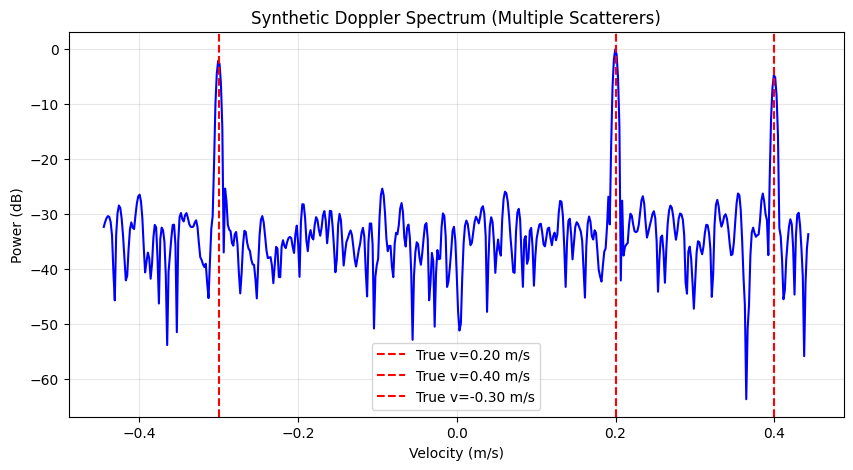

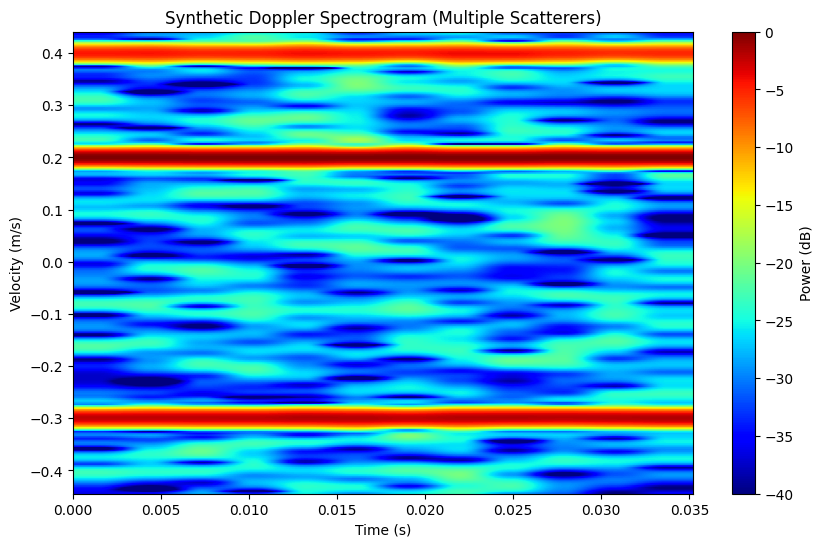

In [2]:
import numpy as np

'''
Clinical Outputs
- Color Doppler: Maps mean velocity in each pixel (red/blue coding).
- Spectral Doppler: Displays velocity distribution over time (spectrogram).
- Power Doppler: Shows signal strength (sensitive to low flow, angle independent)
'''

# Simulated parameters
fs = 40e6        # sampling frequency
prf = 5000       # pulse repetition frequency
f0 = 5e6         # transmit frequency
c = 1540         # sound speed
theta = 30*np.pi/180  # beam-flow angle

# Simulated Doppler sequence (slow-time I/Q data)
num_pulses = 128
true_velocity = 0.3  # m/s
fd_true = 2*true_velocity*f0*np.cos(theta)/c
phase = np.exp(1j*2*np.pi*fd_true*np.arange(num_pulses)/prf)
iq_data = phase + 0.1*(np.random.randn(num_pulses)+1j*np.random.randn(num_pulses))

# Autocorrelation method
R1 = np.sum(iq_data[1:]*np.conj(iq_data[:-1]))
fd_est = np.angle(R1)/(2*np.pi/prf)
v_est = fd_est*c/(2*f0*np.cos(theta))

print(f"True velocity: {true_velocity:.3f} m/s")
print(f"Estimated velocity: {v_est:.3f} m/s")

'''
What you’ll see
• 	Spectrum plot: Multiple peaks at the true velocities (0.2, 0.4, –0.3 m/s).
• 	Spectrogram: Shows how the velocity distribution evolves over time, with noise broadening the bands.
• 	This mimics turbulent blood flow, where multiple velocities coexist in the sample volume.
'''

import numpy as np
import matplotlib.pyplot as plt

# Ultrasound system parameters
c = 1540.0        # sound speed [m/s]
f0 = 5e6          # transmit frequency [Hz]
prf = 5000        # pulse repetition frequency [Hz]
num_pulses = 256  # number of pulses
theta = 30*np.pi/180  # beam-flow angle

# Define multiple scatterers with different velocities
velocities = [0.2, 0.4, -0.3]   # m/s (positive = flow toward probe, negative = away)
amplitudes = [1.0, 0.6, 0.8]    # relative echo strengths

# Generate synthetic I/Q data (slow-time)
n = np.arange(num_pulses)
iq_data = np.zeros(num_pulses, dtype=complex)

for v, amp in zip(velocities, amplitudes):
    fd = 2 * v * f0 * np.cos(theta) / c   # Doppler frequency shift
    iq_data += amp * np.exp(1j * 2*np.pi*fd*n/prf)

# Add noise
iq_data += 0.2*(np.random.randn(num_pulses) + 1j*np.random.randn(num_pulses))

# --- Spectral Doppler (FFT across pulses) ---
window = np.hanning(num_pulses)
spectrum = np.fft.fftshift(np.fft.fft(iq_data * window, 512))
freq_axis = np.fft.fftshift(np.fft.fftfreq(512, d=1/prf))

# Map frequency axis to velocity
vel_axis = freq_axis * c / (2*f0*np.cos(theta))

# Plot Doppler spectrum
plt.figure(figsize=(10,5))
plt.plot(vel_axis, 20*np.log10(np.abs(spectrum)/np.max(np.abs(spectrum))+1e-6), 'b-')
for v in velocities:
    plt.axvline(v, color='r', linestyle='--', label=f'True v={v:.2f} m/s')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Power (dB)')
plt.title('Synthetic Doppler Spectrum (Multiple Scatterers)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# --- Spectrogram over time (short-time FFT) ---
win_len = 64
step = 16
spec = []
for start in range(0, num_pulses-win_len, step):
    seg = iq_data[start:start+win_len] * np.hanning(win_len)
    S = np.fft.fftshift(np.fft.fft(seg, 256))
    spec.append(20*np.log10(np.abs(S)/np.max(np.abs(S))+1e-6))
spec = np.array(spec).T

time_axis = np.arange(spec.shape[1])*step/prf
vel_axis = np.fft.fftshift(np.fft.fftfreq(256, d=1/prf)) * c/(2*f0*np.cos(theta))

plt.figure(figsize=(10,6))
plt.imshow(spec, aspect='auto', origin='lower',
           extent=[time_axis[0], time_axis[-1], vel_axis[0], vel_axis[-1]],
           cmap='jet', vmin=-40, vmax=0)
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Synthetic Doppler Spectrogram (Multiple Scatterers)')
plt.show()

### Workflow for Color Doppler
1. 	Generate B‑mode image
- Simulate tissue scatterers → grayscale background.
2. 	Estimate Doppler velocity per pixel
- For each pixel (or region), compute mean Doppler frequency using autocorrelation across pulses.
- Convert to velocity using the Doppler equation.
3. 	Map velocity to color
- Positive velocity (toward probe) → red.
- Negative velocity (away from probe) → blue.
- Zero or low flow → transparent.
4. 	Overlay color map on B‑mode
- Combine grayscale tissue with semi‑transparent red/blue velocity map.

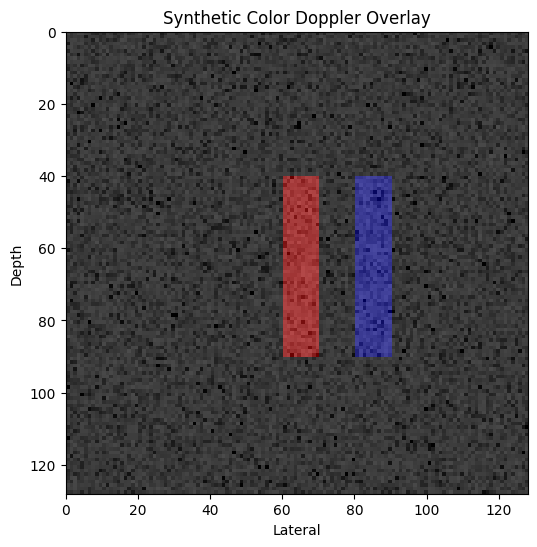

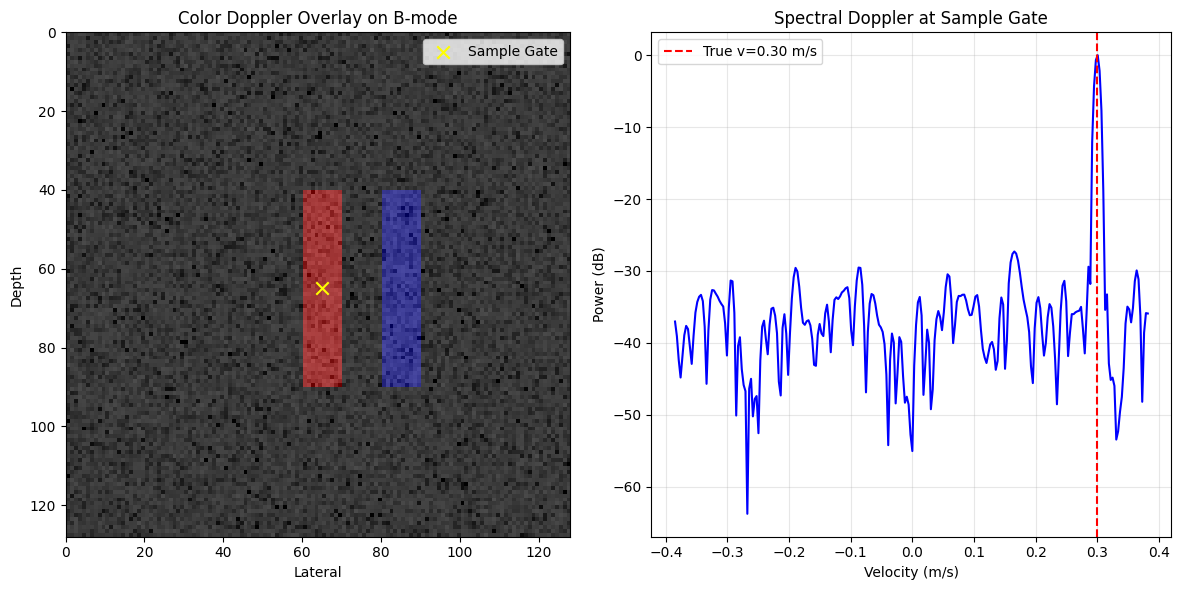

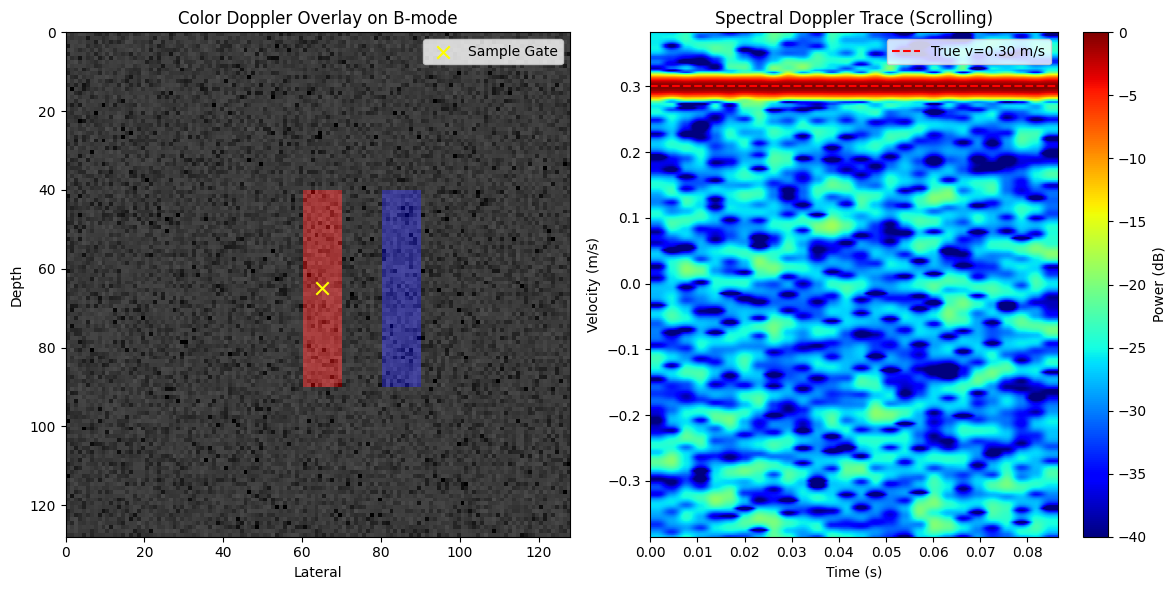

In [5]:
import numpy as np
import matplotlib.pyplot as plt

'''
What you’ll see
• 	A grayscale B‑mode image representing tissue scatterers.
• 	A red vessel (flow toward probe) and a blue vessel (flow away).
• 	Transparent overlay outside the vessel regions.
'''

# Parameters
c = 1540.0
f0 = 5e6
prf = 5000
theta = 0.0
num_pulses = 64
image_size = (128, 128)

# Simulate B-mode background (random scatterers)
np.random.seed(0)
bmode = np.abs(np.random.randn(*image_size))
bmode = 20*np.log10(bmode/np.max(bmode)+1e-6)
bmode = np.clip(bmode, -60, 0)

# Simulate Doppler velocities (synthetic vessel region)
vel_map = np.zeros(image_size)
vel_map[40:90, 60:70] = 0.3   # flow toward probe
vel_map[40:90, 80:90] = -0.25 # flow away from probe

# Generate synthetic I/Q data across pulses
n = np.arange(num_pulses)
doppler_est = np.zeros(image_size)

for i in range(image_size[0]):
    for j in range(image_size[1]):
        v = vel_map[i,j]
        if v != 0:
            fd = 2*v*f0*np.cos(theta)/c
            iq = np.exp(1j*2*np.pi*fd*n/prf) + 0.1*(np.random.randn(num_pulses)+1j*np.random.randn(num_pulses))
            R1 = np.sum(iq[1:]*np.conj(iq[:-1]))
            fd_est = np.angle(R1)/(2*np.pi/prf)
            doppler_est[i,j] = fd_est*c/(2*f0*np.cos(theta))

# Map velocity to color overlay
color_overlay = np.zeros((*image_size, 3))
color_overlay[:,:,0] = np.clip(doppler_est, 0, 0.5)/0.5  # red channel
color_overlay[:,:,2] = np.clip(-doppler_est, 0, 0.5)/0.5 # blue channel

# Plot B-mode + Doppler overlay
plt.figure(figsize=(6,6))
plt.imshow(bmode, cmap='gray', extent=[0, image_size[1], image_size[0], 0])
plt.imshow(color_overlay, alpha=0.7, extent=[0, image_size[1], image_size[0], 0])
plt.title("Synthetic Color Doppler Overlay")
plt.xlabel("Lateral")
plt.ylabel("Depth")
plt.show()

'''
What you’ll see
• 	Left panel: A grayscale B‑mode image with red/blue overlays showing blood flow direction. A yellow “sample gate” marks where the spectral Doppler is measured.
• 	Right panel: A Doppler spectrum showing the velocity distribution at that gate, with a red dashed line marking the true velocity.
'''
import numpy as np
import matplotlib.pyplot as plt

# Ultrasound system parameters
c = 1540.0
f0 = 5e6
prf = 5000
theta = 0.0
num_pulses = 128
image_size = (128, 128)

# --- B-mode background (random scatterers) ---
np.random.seed(0)
bmode = np.abs(np.random.randn(*image_size))
bmode = 20*np.log10(bmode/np.max(bmode)+1e-6)
bmode = np.clip(bmode, -60, 0)

# --- Synthetic vessel with flow ---
vel_map = np.zeros(image_size)
vel_map[40:90, 60:70] = 0.3   # flow toward probe
vel_map[40:90, 80:90] = -0.25 # flow away from probe

# --- Doppler estimation (autocorrelation per pixel) ---
n = np.arange(num_pulses)
doppler_est = np.zeros(image_size)

for i in range(image_size[0]):
    for j in range(image_size[1]):
        v = vel_map[i,j]
        if v != 0:
            fd = 2*v*f0*np.cos(theta)/c
            iq = np.exp(1j*2*np.pi*fd*n/prf) + 0.1*(np.random.randn(num_pulses)+1j*np.random.randn(num_pulses))
            R1 = np.sum(iq[1:]*np.conj(iq[:-1]))
            fd_est = np.angle(R1)/(2*np.pi/prf)
            doppler_est[i,j] = fd_est*c/(2*f0*np.cos(theta))

# --- Color overlay ---
color_overlay = np.zeros((*image_size, 3))
color_overlay[:,:,0] = np.clip(doppler_est, 0, 0.5)/0.5  # red
color_overlay[:,:,2] = np.clip(-doppler_est, 0, 0.5)/0.5 # blue

# --- Spectral Doppler trace at sample gate ---
sample_gate = (65, 65)  # inside vessel
v_gate = vel_map[sample_gate]
fd_gate = 2*v_gate*f0*np.cos(theta)/c
iq_gate = np.exp(1j*2*np.pi*fd_gate*n/prf) + 0.1*(np.random.randn(num_pulses)+1j*np.random.randn(num_pulses))

window = np.hanning(num_pulses)
spectrum = np.fft.fftshift(np.fft.fft(iq_gate*window, 256))
freq_axis = np.fft.fftshift(np.fft.fftfreq(256, d=1/prf))
vel_axis = freq_axis*c/(2*f0*np.cos(theta))

# --- Plot results ---
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Left: B-mode + color Doppler overlay
axes[0].imshow(bmode, cmap='gray', extent=[0,image_size[1],image_size[0],0])
axes[0].imshow(color_overlay, alpha=0.7, extent=[0,image_size[1],image_size[0],0])
axes[0].scatter(sample_gate[1], sample_gate[0], c='yellow', marker='x', s=80, label='Sample Gate')
axes[0].set_title("Color Doppler Overlay on B-mode")
axes[0].set_xlabel("Lateral")
axes[0].set_ylabel("Depth")
axes[0].legend()

# Right: Spectral Doppler trace
axes[1].plot(vel_axis, 20*np.log10(np.abs(spectrum)/np.max(np.abs(spectrum))+1e-6), 'b-')
axes[1].axvline(v_gate, color='r', linestyle='--', label=f'True v={v_gate:.2f} m/s')
axes[1].set_xlabel("Velocity (m/s)")
axes[1].set_ylabel("Power (dB)")
axes[1].set_title("Spectral Doppler at Sample Gate")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

'''
What you’ll see
• 	Left panel: Grayscale B‑mode with red/blue overlay for blood flow, plus a yellow sample gate.
• 	Right panel: A scrolling spectrogram showing Doppler power vs. velocity over time, mimicking the clinical spectral Doppler trace.
'''

import numpy as np
import matplotlib.pyplot as plt

# Ultrasound system parameters
c = 1540.0
f0 = 5e6
prf = 5000
theta = 0.0
num_pulses = 512   # longer sequence for scrolling spectrogram
image_size = (128, 128)

# --- B-mode background ---
np.random.seed(0)
bmode = np.abs(np.random.randn(*image_size))
bmode = 20*np.log10(bmode/np.max(bmode)+1e-6)
bmode = np.clip(bmode, -60, 0)

# --- Synthetic vessel with flow ---
vel_map = np.zeros(image_size)
vel_map[40:90, 60:70] = 0.3   # flow toward probe
vel_map[40:90, 80:90] = -0.25 # flow away from probe

# --- Choose sample gate inside vessel ---
sample_gate = (65, 65)
v_gate = vel_map[sample_gate]

# --- Generate slow-time I/Q data at sample gate ---
n = np.arange(num_pulses)
fd_gate = 2*v_gate*f0*np.cos(theta)/c
iq_gate = np.exp(1j*2*np.pi*fd_gate*n/prf) \
          + 0.2*(np.random.randn(num_pulses)+1j*np.random.randn(num_pulses))

# --- Short-time FFT for scrolling spectrogram ---
win_len = 64
step = 16
spec = []
for start in range(0, num_pulses-win_len, step):
    seg = iq_gate[start:start+win_len] * np.hanning(win_len)
    S = np.fft.fftshift(np.fft.fft(seg, 256))
    spec.append(20*np.log10(np.abs(S)/np.max(np.abs(S))+1e-6))
spec = np.array(spec).T

time_axis = np.arange(spec.shape[1])*step/prf
vel_axis = np.fft.fftshift(np.fft.fftfreq(256, d=1/prf)) * c/(2*f0*np.cos(theta))

# --- Plot results ---
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Left: B-mode + color Doppler overlay
color_overlay = np.zeros((*image_size, 3))
color_overlay[:,:,0] = np.clip(vel_map, 0, 0.5)/0.5  # red
color_overlay[:,:,2] = np.clip(-vel_map, 0, 0.5)/0.5 # blue
axes[0].imshow(bmode, cmap='gray', extent=[0,image_size[1],image_size[0],0])
axes[0].imshow(color_overlay, alpha=0.7, extent=[0,image_size[1],image_size[0],0])
axes[0].scatter(sample_gate[1], sample_gate[0], c='yellow', marker='x', s=80, label='Sample Gate')
axes[0].set_title("Color Doppler Overlay on B-mode")
axes[0].set_xlabel("Lateral")
axes[0].set_ylabel("Depth")
axes[0].legend()

# Right: Scrolling spectral Doppler trace
im = axes[1].imshow(spec, aspect='auto', origin='lower',
                    extent=[time_axis[0], time_axis[-1], vel_axis[0], vel_axis[-1]],
                    cmap='jet', vmin=-40, vmax=0)
axes[1].axhline(v_gate, color='r', linestyle='--', label=f'True v={v_gate:.2f} m/s')
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Velocity (m/s)")
axes[1].set_title("Spectral Doppler Trace (Scrolling)")
axes[1].legend()
plt.colorbar(im, ax=axes[1], label='Power (dB)')

plt.tight_layout()
plt.show()

## Ultrasound image reconstruction: B‑mode, M‑mode, and 3D/4D imaging
Ultrasound images are reconstructed by aligning and summing channel RF data to focus at spatial points, then detecting the envelope and compressing dynamic range. Let’s get practical and precise across B‑mode, M‑mode, and 3D/4D.

### Core building blocks
- Transmit/receive model: A pulse (often Gaussian‑modulated or coded) is sent; echoes are received by each array element and sampled as RF.
- Beamforming (DAS/MV): Align each element’s RF with the expected delay to a focus point, then sum. Delay‑and‑sum is the workhorse; minimum‑variance (MV/Capon) improves resolution at higher compute cost.
- Envelope detection: Apply analytic signal via Hilbert transform, then take magnitude.
- Log compression: Map large dynamic range to display, e.g., clip at −60 dB to 0 dB.

### B‑mode reconstruction (2D grayscale)
B‑mode forms a 2D cross‑section by beamforming along scan lines and depths, then envelope and log compress.
- Scan grid: Define lateral positions  and depths .
- Delays: For element position $\mathbf{p_{\mathnormal{m}}}=(x_m,0,0)$ and voxel $\mathbf{r}=(x,0,z)$, the round‑trip delay is .
- DAS output:
$s(x,z)=\sum _{m=1}^Mw_m(x,z)\, u_m\! \left( t_m\right)$
- with apodization $w_m$. Use fractional delays (interpolation) to reduce blur.

### M‑mode reconstruction (motion along one beam vs time)
M‑mode samples repeatedly along one beam line, showing motion of structures over time.
- Select a beam: Fix lateral . For each frame , beamform an A‑line .
- Stack over time: Create an image with vertical axis  and horizontal axis  (time).
- Velocity cues: Tissue motion shifts peaks; cardiac valves show characteristic waveforms.

### 3D/4D reconstruction (volumetric and time-resolved)
3D collects multiple 2D slices or uses matrix arrays; 4D adds time. Plane‑wave compounding or mechanical sweeps fill a volume.
- Volumetric grid: Define  voxels. For a linear array with elevational compounding, aggregate multiple tilted slices; for matrix arrays, beamform directly in 3D.
- 3D delays:

- Sum across  as in DAS. Apply envelope and log compression per voxel.
- Compounding: Combine volumes at different transmit angles to improve contrast.

### Practical enhancements and pitfalls
- Fractional delays: Linear is fast; higher‑order Lagrange or spline improves fidelity.
- Apodization and coherence: Short‑lag spatial coherence (SLSC) can boost contrast in clutter.
- Speed of sound mismatch: Errors distort geometry; adaptive SoS can refine focusing.
- IQ processing: Demodulate to baseband before DAS to reduce sampling burden and enable precise envelope detection.
- Dynamic receive focusing: In line scanning, adapt delays with depth for each element to maintain focus across the A‑line.
- Plane‑wave compounding: Multi‑angle transmits reduce speckle variance and enhance contrast; balance angle count vs frame rate.

/tmp/ipykernel_16223/2536725338.py:336: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


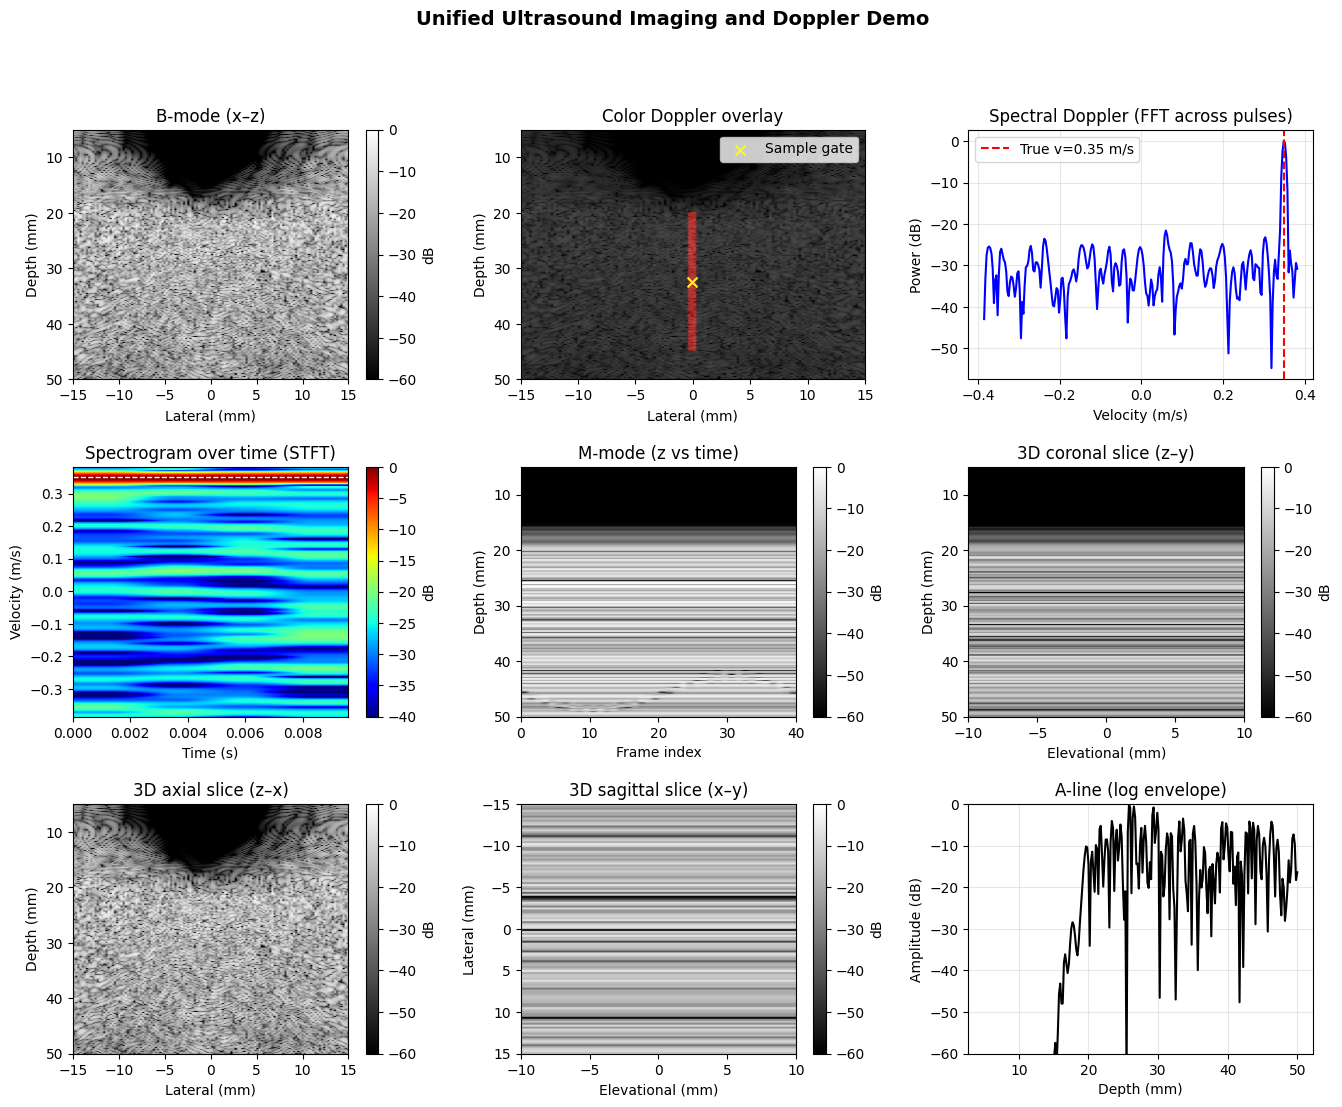

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

'''
• 	This single script synthesizes RF, reconstructs B‑mode, produces M‑mode, estimates color Doppler via lag‑1 autocorrelation, computes spectral Doppler (single frame and scrolling spectrogram), and shows pseudo‑3D slices by stacking the B‑mode image across an elevational axis.
• 	For realism and speed, vectorize delay calculations, demodulate to I/Q before DAS, and consider fractional delay filters beyond linear interpolation. If you have actual RF acquisitions, share the geometry and sampling format and we can adapt the beamformer and Doppler modules to your setup.
'''


# =============================================================================
# System and probe parameters
# =============================================================================
c = 1540.0         # speed of sound [m/s]
f0 = 5e6           # center frequency [Hz]
fs = 40e6          # sampling frequency [Hz]
wavelength = c / f0

n_elements = 64
aperture = 30e-3
elem_x = np.linspace(-aperture/2, aperture/2, n_elements)
elem_pos = np.stack([elem_x, np.zeros(n_elements), np.zeros(n_elements)], axis=1)

# Imaging grids (2D and pseudo-3D)
x_grid = np.linspace(-0.015, 0.015, 128)      # lateral [m]
z_grid = np.linspace(0.005, 0.05, 256)        # depth [m]
y_grid = np.linspace(-0.01, 0.01, 64)         # elevational [m] (synthetic)

# Time axis for RF samples (axial window)
n_ax = 4096
t_ax = np.arange(n_ax) / fs

# =============================================================================
# Pulse and simple phantom
# =============================================================================
def gaussian_tone(t, f0, bw_frac=0.6):
    tau = 2.0 / (bw_frac * f0)                 # pulse duration scale
    g = np.exp(-((t - t[-1]/5.0)**2) / (2 * tau**2))  # center early
    return g * np.cos(2*np.pi*f0*t)

pulse = gaussian_tone(t_ax, f0, bw_frac=0.7)
pulse /= np.max(np.abs(pulse))

# Phantom scatterers: tissue + a vessel line with flow
np.random.seed(1)
# Tissue: random scatterers in a rectangular region
num_tissue = 600
tissue_x = np.random.uniform(x_grid.min(), x_grid.max(), num_tissue)
tissue_z = np.random.uniform(z_grid.min(), z_grid.max(), num_tissue)
tissue_mag = np.random.uniform(0.3, 1.0, num_tissue)

# Vessel: a narrow vertical band with stronger scattering
vessel_x_center = 0.0
vessel_width = 2e-3
num_vessel = 120
vessel_x = np.random.uniform(vessel_x_center - vessel_width/2, vessel_x_center + vessel_width/2, num_vessel)
vessel_z = np.random.uniform(0.02, 0.045, num_vessel)
vessel_mag = np.random.uniform(0.6, 1.0, num_vessel)

scatterer_pos = np.stack([np.concatenate([tissue_x, vessel_x]),
                          np.zeros(num_tissue + num_vessel),
                          np.concatenate([tissue_z, vessel_z])], axis=1)
scatterer_mag = np.concatenate([tissue_mag, vessel_mag])

# Doppler flow map for the vessel (used later)
theta = 0.0  # beam-flow angle for demo (0 deg)
vel_map = np.zeros((len(z_grid), len(x_grid)))
vx_idx = np.argmin(np.abs(x_grid - vessel_x_center))
vz_start = np.argmin(np.abs(z_grid - 0.02))
vz_end   = np.argmin(np.abs(z_grid - 0.045))
vel_map[vz_start:vz_end, vx_idx-1: vx_idx+2] = 0.35  # toward probe

# =============================================================================
# RF synthesis (time domain) for one transmit (plane-wave broadside)
# =============================================================================
def attenuation_np_per_m(f_MHz=5.0, alpha_db_per_MHz_cm=0.7):
    # Convert ~dB/MHz/cm to Np/m (approx)
    return alpha_db_per_MHz_cm * f_MHz * 0.1151  # Np/cm -> Np/m

alpha_np_m = attenuation_np_per_m(f0/1e6, 0.7)

def synthesize_rf(elem_pos, scatterer_pos, scatterer_mag, pulse, c, fs, t_ax):
    n_elements = elem_pos.shape[0]
    rf = np.zeros((n_elements, len(t_ax)), dtype=np.float32)
    for m in range(n_elements):
        acc = np.zeros(len(t_ax), dtype=np.float32)
        xm, ym, zm = elem_pos[m]
        for (xs, ys, zs), mag in zip(scatterer_pos, scatterer_mag):
            r = np.sqrt((xs - xm)**2 + (ys - ym)**2 + (zs - zm)**2)
            tau = 2 * r / c
            idx = tau * fs
            i0 = int(np.floor(idx))
            frac = idx - i0
            if 0 <= i0 < len(t_ax):
                length = min(len(t_ax) - i0, len(pulse))
                att = np.exp(-alpha_np_m * (2 * r))  # two-way attenuation
                spread = 1.0 / (r + 1e-6)           # 1/r spreading
                amp = mag * att * spread
                acc[i0:i0+length] += amp * (1-frac) * pulse[:length]
                if i0 + 1 < len(t_ax):
                    length2 = min(len(t_ax) - (i0+1), len(pulse))
                    acc[i0+1:i0+1+length2] += amp * frac * pulse[:length2]
        rf[m, :] = acc
    return rf

rf = synthesize_rf(elem_pos, scatterer_pos, scatterer_mag, pulse, c, fs, t_ax)

# =============================================================================
# Delay-and-sum (DAS) beamforming for B-mode (fractional delays)
# =============================================================================
def das_bmode(rf, elem_x, x_grid, z_grid, c, fs, apod='hann'):
    M, N = rf.shape
    w = np.hanning(M) if apod == 'hann' else np.ones(M)
    img = np.zeros((len(z_grid), len(x_grid)), dtype=np.float32)
    for ix, x in enumerate(x_grid):
        for iz, z in enumerate(z_grid):
            s = 0.0
            for m in range(M):
                r = np.sqrt((x - elem_x[m])**2 + z**2)
                tau = 2 * r / c
                idx = tau * fs
                i0 = int(np.floor(idx))
                frac = idx - i0
                if 0 <= i0 < N - 1:
                    u = (1 - frac) * rf[m, i0] + frac * rf[m, i0 + 1]
                    s += w[m] * u
            img[iz, ix] = np.abs(s)
    # Envelope & log compression
    img = 20 * np.log10(img / (np.max(img) + 1e-9) + 1e-6)
    img = np.clip(img, -60, 0)
    return img

bmode = das_bmode(rf, elem_x, x_grid, z_grid, c, fs)

# =============================================================================
# M-mode (single beam x0 vs time): simulate a few frames with a moving point
# =============================================================================
def das_aline(rf, elem_x, x0, z_grid, c, fs, apod='hann'):
    M, N = rf.shape
    w = np.hanning(M) if apod == 'hann' else np.ones(M)
    aline_env = np.zeros(len(z_grid), dtype=np.float32)
    for iz, z in enumerate(z_grid):
        s = 0.0
        for m in range(M):
            r = np.sqrt((x0 - elem_x[m])**2 + z**2)
            tau = 2 * r / c
            idx = tau * fs
            i0 = int(np.floor(idx))
            frac = idx - i0
            if 0 <= i0 < N - 1:
                u = (1 - frac) * rf[m, i0] + frac * rf[m, i0 + 1]
                s += w[m] * u
        aline_env[iz] = np.abs(s)
    return aline_env

# Create synthetic motion: move one scatterer sinusoidally and resynthesize for a few frames
num_frames = 40
x0_beam = 0.0
mmode_stack = []
for k in range(num_frames):
    # Move a single bright point in depth for demo
    moving_scatter = np.array([[0.0, 0.0, 0.03 + 0.003*np.sin(2*np.pi*k/num_frames)]])
    moving_mag = np.array([1.0])
    scat_all = np.vstack([scatterer_pos, moving_scatter])
    mag_all  = np.concatenate([scatterer_mag, moving_mag])
    rf_k = synthesize_rf(elem_pos, scat_all, mag_all, pulse, c, fs, t_ax)
    aline_env = das_aline(rf_k, elem_x, x0_beam, z_grid, c, fs)
    mmode_stack.append(aline_env)
mmode_stack = np.array(mmode_stack).T
mmode_img = 20*np.log10(mmode_stack/(np.max(mmode_stack)+1e-9) + 1e-6)
mmode_img = np.clip(mmode_img, -60, 0)

# =============================================================================
# Color Doppler (mean velocity map via lag-1 autocorrelation) and Spectral Doppler
# =============================================================================
prf = 5000
num_pulses = 128
n = np.arange(num_pulses)

def doppler_mean_velocity(fd_phase_seq, prf, f0, c, theta):
    # Estimate mean fd from phase of lag-1 autocorrelation
    R1 = np.sum(fd_phase_seq[1:] * np.conj(fd_phase_seq[:-1]))
    fd_est = np.angle(R1) / (2*np.pi/prf)
    v_est = fd_est * c / (2 * f0 * np.cos(theta + 1e-9))
    return v_est

# Build pixelwise Doppler I/Q sequences only for vessel region to keep runtime modest
doppler_est = np.zeros_like(vel_map)
noise_level = 0.15
for iz in range(vz_start, vz_end):
    for ix in range(vx_idx-2, vx_idx+3):
        v = vel_map[iz, ix]
        fd = 2*v*f0*np.cos(theta)/c
        iq = np.exp(1j * 2*np.pi*fd*n/prf) + noise_level*(np.random.randn(num_pulses) + 1j*np.random.randn(num_pulses))
        doppler_est[iz, ix] = doppler_mean_velocity(iq, prf, f0, c, theta)

# Color map
color_overlay = np.zeros((len(z_grid), len(x_grid), 3), dtype=np.float32)
vmax = 0.5
color_overlay[..., 0] = np.clip(doppler_est, 0, vmax) / vmax   # red (toward)
color_overlay[..., 2] = np.clip(-doppler_est, 0, vmax) / vmax  # blue (away)

# Spectral Doppler at a gate inside the vessel
gate_ix, gate_iz = vx_idx, (vz_start + vz_end)//2
v_gate = vel_map[gate_iz, gate_ix]
fd_gate = 2*v_gate*f0*np.cos(theta)/c
iq_gate = np.exp(1j*2*np.pi*fd_gate*n/prf) + 0.2*(np.random.randn(num_pulses) + 1j*np.random.randn(num_pulses))
window = np.hanning(num_pulses)
spec = np.fft.fftshift(np.fft.fft(iq_gate * window, 256))
freq_axis = np.fft.fftshift(np.fft.fftfreq(256, d=1/prf))
vel_axis = freq_axis * c / (2*f0*np.cos(theta + 1e-9))
spec_db = 20*np.log10(np.abs(spec)/np.max(np.abs(spec)) + 1e-6)

# Scrolling spectrogram (short-time FFT)
win_len, step = 64, 16
spec_t = []
for start in range(0, num_pulses - win_len, step):
    seg = iq_gate[start:start+win_len] * np.hanning(win_len)
    S = np.fft.fftshift(np.fft.fft(seg, 256))
    spec_t.append(20*np.log10(np.abs(S)/np.max(np.abs(S)) + 1e-6))
spec_t = np.array(spec_t).T
time_axis = np.arange(spec_t.shape[1]) * step / prf
vel_axis_t = np.fft.fftshift(np.fft.fftfreq(256, d=1/prf)) * c/(2*f0*np.cos(theta + 1e-9))

# =============================================================================
# Pseudo-3D slice: reconstruct multiple lateral slices and stack in y
# (For a real 3D, you would have a 2D matrix array; here we reuse DAS in x–z and copy across y)
# =============================================================================
vol3d = np.repeat(bmode[:, :, np.newaxis], len(y_grid), axis=2)  # (z, x, y)
# Show three orthogonal slices
slice_axial = bmode                                   # z vs x
slice_coronal = vol3d[:, x_grid.size//2, :]           # z vs y
slice_sagittal = vol3d[z_grid.size//2, :, :]          # x vs y

# =============================================================================
# Visualization
# =============================================================================
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# B-mode (x–z)
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(bmode, cmap='gray',
                 extent=[x_grid[0]*1e3, x_grid[-1]*1e3, z_grid[-1]*1e3, z_grid[0]*1e3],
                 aspect='auto', vmin=-60, vmax=0)
ax1.set_title('B-mode (x–z)')
ax1.set_xlabel('Lateral (mm)')
ax1.set_ylabel('Depth (mm)')
plt.colorbar(im1, ax=ax1, label='dB')

# Color Doppler overlay on B-mode
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(bmode, cmap='gray',
           extent=[x_grid[0]*1e3, x_grid[-1]*1e3, z_grid[-1]*1e3, z_grid[0]*1e3],
           aspect='auto', vmin=-60, vmax=0)
ax2.imshow(color_overlay,
           extent=[x_grid[0]*1e3, x_grid[-1]*1e3, z_grid[-1]*1e3, z_grid[0]*1e3],
           aspect='auto', alpha=0.7)
ax2.scatter(x_grid[gate_ix]*1e3, z_grid[gate_iz]*1e3, c='yellow', s=50, marker='x', label='Sample gate')
ax2.set_title('Color Doppler overlay')
ax2.set_xlabel('Lateral (mm)')
ax2.set_ylabel('Depth (mm)')
ax2.legend()

# Spectral Doppler (single FFT)
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(vel_axis, spec_db, 'b-')
ax3.axvline(v_gate, color='r', linestyle='--', label=f'True v={v_gate:.2f} m/s')
ax3.set_title('Spectral Doppler (FFT across pulses)')
ax3.set_xlabel('Velocity (m/s)')
ax3.set_ylabel('Power (dB)')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Scrolling spectrogram
ax4 = fig.add_subplot(gs[1, 0])
im4 = ax4.imshow(spec_t, origin='lower', aspect='auto',
                 extent=[time_axis[0], time_axis[-1], vel_axis_t[0], vel_axis_t[-1]],
                 cmap='jet', vmin=-40, vmax=0)
ax4.axhline(v_gate, color='w', linestyle='--', linewidth=1)
ax4.set_title('Spectrogram over time (STFT)')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Velocity (m/s)')
plt.colorbar(im4, ax=ax4, label='dB')

# M-mode (z vs frame)
ax5 = fig.add_subplot(gs[1, 1])
im5 = ax5.imshow(mmode_img, cmap='gray',
                 extent=[0, num_frames, z_grid[-1]*1e3, z_grid[0]*1e3],
                 aspect='auto', vmin=-60, vmax=0)
ax5.set_title('M-mode (z vs time)')
ax5.set_xlabel('Frame index')
ax5.set_ylabel('Depth (mm)')
plt.colorbar(im5, ax=ax5, label='dB')

# 3D slices: axial and coronal
ax6 = fig.add_subplot(gs[1, 2])
im6 = ax6.imshow(slice_coronal, cmap='gray',
                 extent=[y_grid[0]*1e3, y_grid[-1]*1e3, z_grid[-1]*1e3, z_grid[0]*1e3],
                 aspect='auto', vmin=-60, vmax=0)
ax6.set_title('3D coronal slice (z–y)')
ax6.set_xlabel('Elevational (mm)')
ax6.set_ylabel('Depth (mm)')
plt.colorbar(im6, ax=ax6, label='dB')

ax7 = fig.add_subplot(gs[2, 0])
im7 = ax7.imshow(slice_axial, cmap='gray',
                 extent=[x_grid[0]*1e3, x_grid[-1]*1e3, z_grid[-1]*1e3, z_grid[0]*1e3],
                 aspect='auto', vmin=-60, vmax=0)
ax7.set_title('3D axial slice (z–x)')
ax7.set_xlabel('Lateral (mm)')
ax7.set_ylabel('Depth (mm)')
plt.colorbar(im7, ax=ax7, label='dB')

ax8 = fig.add_subplot(gs[2, 1])
im8 = ax8.imshow(slice_sagittal, cmap='gray',
                 extent=[y_grid[0]*1e3, y_grid[-1]*1e3, x_grid[-1]*1e3, x_grid[0]*1e3],
                 aspect='auto', vmin=-60, vmax=0)
ax8.set_title('3D sagittal slice (x–y)')
ax8.set_xlabel('Elevational (mm)')
ax8.set_ylabel('Lateral (mm)')
plt.colorbar(im8, ax=ax8, label='dB')

# B-mode line example (one A-line, envelope)
ax9 = fig.add_subplot(gs[2, 2])
aline_env = das_aline(rf, elem_x, x0_beam, z_grid, c, fs)
env_log = 20*np.log10(aline_env/(np.max(aline_env)+1e-9) + 1e-6)
ax9.plot(z_grid*1e3, env_log, 'k-')
ax9.set_title('A-line (log envelope)')
ax9.set_xlabel('Depth (mm)')
ax9.set_ylabel('Amplitude (dB)')
ax9.grid(True, alpha=0.3)
ax9.set_ylim(-60, 0)

plt.suptitle('Unified Ultrasound Imaging and Doppler Demo', fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

### Ultrasound AI inference engine for on‑device anomaly detection
You want a practical, robust engine that runs on-device and flags tumors, lesions, and organ boundaries in real time. Below is a concise blueprint plus runnable code to get you from data to on-edge inference with quantization and lightweight post-processing. Literature signals strong momentum in ultrasound AI across detection, segmentation, and reporting, with emerging few‑shot and multimodal models you can distill for edge use. Fine‑grained anomaly classification and multimodal reasoning are advancing (e.g., few‑shot CLIP adaptations; generalist sono VLM), but on-device constraints favor compact CNN/UNet plus distillation.

#### System overview and goals
- Inputs: B‑mode frames (and optional Doppler/color maps) from the probe.
- Outputs:
- Segmentation masks for organ boundaries and lesion candidates.
- Anomaly scores (benign/malignant risk, atypical tissue).
- Overlays and structured findings for clinicians.
- Constraints: Low latency (<50 ms/frame), <50–150 MB RAM, GPU optional, CPU acceptable. Use quantization, pruning, and distillation to fit edge constraints.

#### Model design and tasks
- Backbone: Lightweight encoder (MobileNetV3‑Small or EfficientNet‑Lite) for feature extraction.
- Heads:
  - Segmentation head (UNet‑lite): Organ boundaries, lesion masks.
  - Detection/classification head: Patch-level anomaly score; optional small detector (Nano‑YOLO) for bounding boxes.
- Training strategy:
  - Multi-task loss: Dice + BCE for segmentation; focal or BCE for anomaly head.
  - Class imbalance handling: focal loss, strong augmentations (elastic, noise, speckle).
  - Distillation from a larger teacher (e.g., ResNet‑UNet) to a mobile student.
- Optional multimodal cues: Text prompts or clinician metadata can be leveraged during training; distill to compact heads for on-device inference.

Reviews highlight AI’s impact on ultrasound across detection, segmentation, and workflow; edge deployment benefits from compact models and explainability overlays.

#### Data and labeling
- Datasets: Curate organ-specific sets (e.g., liver, thyroid, breast, obstetric). Include varied scanners and presets.
- Labels:
  - Per-pixel masks for organ boundaries and lesions.
  - Lesion attributes: size, echogenicity patterns.
  - Slice-wise anomaly tags for weak supervision.
- Preprocessing: Intensity standardization, speckle-aware augmentation, depth/lateral calibration.

#### On‑device pipeline and optimization
- Runtime steps:
- Preprocess frame (normalize, resize, optional denoise).
- Run encoder + heads (segmentation and anomaly).
  - Post-process masks (threshold, morphological clean, connected components).
  - Compute regions, contours, measurements; color overlays.
  - Package findings; display and send summaries.
- Optimization:
  - Post‑training quantization (INT8) or QAT.
  - Pruning and layer fusion; export to ONNX/TFLite.
  - Distill teacher→student to preserve accuracy on edge hardware.
- Explainability: Grad‑CAM or attention maps for clinician trust; map to overlays and structured outputs.




Epoch 1/2
24/24 - 62s - 3s/step - cls_logit_binary_accuracy: 0.4792 - cls_logit_loss: 0.7361 - loss: 2.1854 - seg_logits_loss: 1.4493 - seg_logits_seg_iou: 0.2135 - val_cls_logit_binary_accuracy: 0.5417 - val_cls_logit_loss: 0.6938 - val_loss: 2.1746 - val_seg_logits_loss: 1.4808 - val_seg_logits_seg_iou: 2.4971e-10
Epoch 2/2
24/24 - 5s - 224ms/step - cls_logit_binary_accuracy: 0.4792 - cls_logit_loss: 0.6657 - loss: 1.7078 - seg_logits_loss: 1.0420 - seg_logits_seg_iou: 0.7616 - val_cls_logit_binary_accuracy: 0.5417 - val_cls_logit_loss: 0.6924 - val_loss: 2.0125 - val_seg_logits_loss: 1.3201 - val_seg_logits_seg_iou: 2.4971e-10
INFO:tensorflow:Assets written to: /tmp/tmpr1rv_423/assets


INFO:tensorflow:Assets written to: /tmp/tmpr1rv_423/assets


Saved artifact at '/tmp/tmpr1rv_423'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='keras_tensor_285')
Output Type:
  List[TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  139120501643344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120618145744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120618152608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120618145216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120618146976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120618145040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120617935920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120617934864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120617942784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120

W0000 00:00:1764277333.096498    4947 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1764277333.096563    4947 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-11-27 13:02:13.096822: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpr1rv_423
2025-11-27 13:02:13.102226: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-27 13:02:13.102277: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpr1rv_423
2025-11-27 13:02:13.173933: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-27 13:02:14.334583: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpr1rv_423
2025-11-27 13:02:14.667472: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 1570650 microseconds.


Saved FP32 TFLite: ultrasound_edge_fp32.tflite (0.28 MB)
INFO:tensorflow:Assets written to: /tmp/tmp5ttpkv8l/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ttpkv8l/assets


Saved artifact at '/tmp/tmp5ttpkv8l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='keras_tensor_285')
Output Type:
  List[TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  139120501643344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120618145744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120618152608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120618145216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120618146976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120618145040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120617935920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120617934864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120617942784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139120

/home/akzare/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1764277355.693447    4947 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1764277355.693608    4947 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-11-27 13:02:35.694246: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5ttpkv8l
2025-11-27 13:02:35.713609: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-11-27 13:02:35.713738: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp5ttpkv8l
2025-11-27 13:02:35.969314: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-11-27 13:02:37.400062: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp5ttp

Saved INT8 TFLite: ultrasound_edge_int8.tflite (0.12 MB)
TFLite FP32: anomaly_score=0.320, mask_sum=0
TFLite INT8: anomaly_score=0.320, mask_sum=0


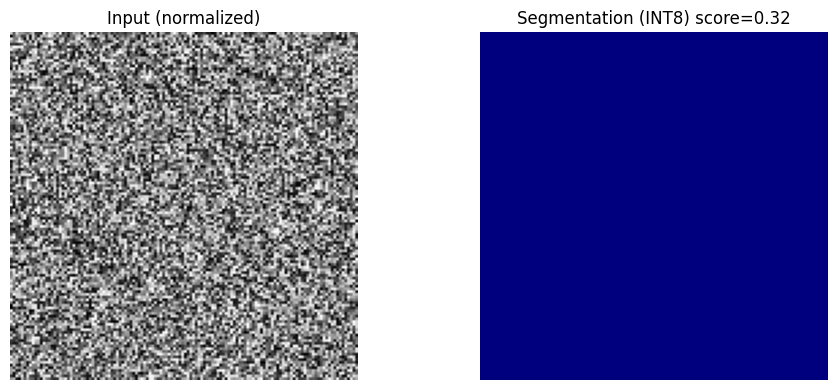

In [7]:
# ultrasound_edge_ai_full_corrected.py
import numpy as np
import tensorflow as tf

# =============================================================================
# Config
# =============================================================================
IMG_SIZE = (128, 128)   # demo resolution
BATCH = 4
EPOCHS = 2
SEED = 7

tf.random.set_seed(SEED)
np.random.seed(SEED)

# =============================================================================
# Synthetic dataset (replace with real ultrasound frames/masks)
# =============================================================================
def make_synthetic_dataset(num=64, img_size=IMG_SIZE):
    H, W = img_size
    imgs = np.random.rand(num, H, W, 1).astype(np.float32)
    masks = np.zeros((num, H, W, 1), dtype=np.float32)
    labels = np.random.randint(0, 2, size=(num, 1)).astype(np.float32)
    yy, xx = np.mgrid[:H, :W]
    for i in range(num):
        cx, cy = np.random.randint(W//4, 3*W//4), np.random.randint(H//4, 3*W//4)
        r = np.random.randint(min(H, W)//8, min(H, W)//6)
        circle = ((xx - cx)**2 + (yy - cy)**2) < r**2
        masks[i, circle, 0] = 1.0
        imgs[i, :, :, 0] = (imgs[i, :, :, 0] * 0.6 + 0.4 * circle.astype(np.float32))
    imgs = (imgs - 0.5) / 0.5  # normalize to [-1,1]
    return imgs, masks, labels

train_imgs, train_masks, train_labels = make_synthetic_dataset(96)
val_imgs, val_masks, val_labels = make_synthetic_dataset(24)

def tf_dataset(imgs, masks, labels, batch=BATCH, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((imgs, masks, labels))
    def pack(x, y_seg, y_cls):
        return x, {'seg_logits': y_seg, 'cls_logit': y_cls}
    ds = ds.map(pack, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(len(imgs), seed=SEED)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = tf_dataset(train_imgs, train_masks, train_labels)
val_ds   = tf_dataset(val_imgs, val_masks, val_labels, shuffle=False)

# =============================================================================
# UNet-lite model
# =============================================================================
def dw_sep_block(x, filters, k=3, s=1):
    x = tf.keras.layers.DepthwiseConv2D(k, s, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, 1, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def build_unet_lite(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1), base_chs=(16,24,40,80,112)):
    inp = tf.keras.Input(shape=input_shape)

    # Encoder
    x0 = tf.keras.layers.Conv2D(base_chs[0], 3, 2, padding='same', use_bias=False)(inp)  # H/2
    x0 = tf.keras.layers.BatchNormalization()(x0)
    x0 = tf.keras.layers.Activation('relu')(x0)

    x1 = dw_sep_block(x0, base_chs[1], s=2)  # H/4
    x2 = dw_sep_block(x1, base_chs[2], s=2)  # H/8
    x3 = dw_sep_block(x2, base_chs[3], s=2)  # H/16
    x4 = dw_sep_block(x3, base_chs[4], s=1)  # bottleneck H/16

    # Decoder
    d3 = dw_sep_block(tf.keras.layers.Concatenate()([x4, x3]), base_chs[3])  # H/16
    u2 = tf.keras.layers.Conv2DTranspose(base_chs[2], 2, 2, padding='same')(d3)  # H/8
    d2 = dw_sep_block(tf.keras.layers.Concatenate()([u2, x2]), base_chs[2])
    u1 = tf.keras.layers.Conv2DTranspose(base_chs[1], 2, 2, padding='same')(d2)  # H/4
    d1 = dw_sep_block(tf.keras.layers.Concatenate()([u1, x1]), base_chs[1])
    u0 = tf.keras.layers.Conv2DTranspose(base_chs[0], 2, 2, padding='same')(d1)  # H/2
    d0 = dw_sep_block(tf.keras.layers.Concatenate()([u0, x0]), base_chs[0])
    u_final = tf.keras.layers.Conv2DTranspose(base_chs[0], 2, 2, padding='same')(d0)      # H
    seg_logits = tf.keras.layers.Conv2D(1, 1, activation=None, name='seg_logits')(u_final)

    # Classification head
    cls = tf.keras.layers.GlobalAveragePooling2D()(x4)
    cls = tf.keras.layers.Dense(64, activation='relu')(cls)
    cls_logit = tf.keras.layers.Dense(1, activation=None, name='cls_logit')(cls)

    return tf.keras.Model(inputs=inp, outputs=[seg_logits, cls_logit], name='UNetLite_Keras')

model = build_unet_lite()

# =============================================================================
# Losses and metrics
# =============================================================================
def dice_loss(y_true, y_pred, eps=1e-6):
    y_prob = tf.nn.sigmoid(y_pred)
    num = 2.0 * tf.reduce_sum(y_prob * y_true) + eps
    den = tf.reduce_sum(y_prob) + tf.reduce_sum(y_true) + eps
    return 1.0 - (num / den)

def bce_logits(y_true, y_pred):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))

def iou_metric(y_true, y_pred, thr=0.5, eps=1e-6):
    y_prob = tf.nn.sigmoid(y_pred)
    y_pred_bin = tf.cast(y_prob > thr, tf.float32)
    inter = tf.reduce_sum(y_pred_bin * y_true)
    union = tf.reduce_sum(y_pred_bin) + tf.reduce_sum(y_true) - inter + eps
    return (inter + eps) / union

class SegIoU(tf.keras.metrics.Metric):
    def __init__(self, name='seg_iou', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(shape=(), initializer='zeros', name='total')
        self.count = self.add_weight(shape=(), initializer='zeros', name='count')
    def update_state(self, y_true, y_pred, sample_weight=None):
        iou = iou_metric(y_true, y_pred)
        self.total.assign_add(iou)
        self.count.assign_add(1.0)
    def result(self):
        return self.total / tf.maximum(self.count, 1.0)
    def reset_states(self):
        self.total.assign(0.0); self.count.assign(0.0)

def seg_loss_wrapper(y_true, y_pred):
    return dice_loss(y_true, y_pred) + bce_logits(y_true, y_pred)

def cls_loss_wrapper(y_true, y_pred):
    return bce_logits(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={'seg_logits': seg_loss_wrapper, 'cls_logit': cls_loss_wrapper},
    metrics={'seg_logits': [SegIoU()], 'cls_logit': [tf.keras.metrics.BinaryAccuracy(threshold=0.5)]}
)

# =============================================================================
# Train (demo)
# =============================================================================
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, verbose=2)

# =============================================================================
# Export to TFLite
# =============================================================================
def representative_dataset_gen(num_calib=32):
    for i in range(num_calib):
        sample = np.random.rand(1, IMG_SIZE[0], IMG_SIZE[1], 1).astype(np.float32)
        sample = (sample - 0.5) / 0.5
        yield [sample]

def export_tflite_fp32(model, path='ultrasound_edge_fp32.tflite'):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(path, 'wb') as f:
        f.write(tflite_model)
    print(f"Saved FP32 TFLite: {path} ({len(tflite_model)/1e6:.2f} MB)")

def export_tflite_int8(model, path='ultrasound_edge_int8.tflite'):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8   # full integer
    converter.inference_output_type = tf.uint8
    tflite_model = converter.convert()
    with open(path, 'wb') as f:
        f.write(tflite_model)
    print(f"Saved INT8 TFLite: {path} ({len(tflite_model)/1e6:.2f} MB)")

export_tflite_fp32(model, 'ultrasound_edge_fp32.tflite')
export_tflite_int8(model, 'ultrasound_edge_int8.tflite')

# =============================================================================
# TFLite inference (robust to output shapes)
# =============================================================================
def tflite_infer(tflite_path, image):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    inp_idx = input_details[0]['index']
    if input_details[0]['dtype'] == np.uint8:
        scale, zero = input_details[0]['quantization']
        scale = scale or 1.0
        zero = zero or 0
        image_q = np.clip(image / scale + zero, 0, 255).astype(np.uint8)
    else:
        image_q = image.astype(np.float32)

    interpreter.set_tensor(inp_idx, image_q)
    interpreter.invoke()

    # Output order: [seg_logits, cls_logit]
    seg_out = interpreter.get_tensor(output_details[0]['index'])
    cls_out = interpreter.get_tensor(output_details[1]['index'])

    def deq(out_tensor, details):
        if details['dtype'] == np.uint8:
            s, z = details['quantization']
            s = s or 1.0; z = z or 0
            return s * (out_tensor.astype(np.float32) - z)
        return out_tensor.astype(np.float32)

    seg_logits = deq(seg_out, output_details[0])
    cls_logit  = deq(cls_out, output_details[1])

    seg_prob = 1.0 / (1.0 + np.exp(-seg_logits))

    # Handle different possible shapes: (1,H,W,1), (1,H,W), or (H,W)
    if seg_prob.ndim == 4:
        seg_mask = (seg_prob[0, :, :, 0] > 0.5).astype(np.uint8)
    elif seg_prob.ndim == 3:
        seg_mask = (seg_prob[0, :, :] > 0.5).astype(np.uint8)
    elif seg_prob.ndim == 2:
        seg_mask = (seg_prob > 0.5).astype(np.uint8)
    else:
        raise ValueError(f"Unexpected seg_prob shape {seg_prob.shape}")

    cls_score = float(1.0 / (1.0 + np.exp(-cls_logit)).reshape(-1)[0])

    return seg_mask, cls_score

# Test TFLite inference
test_img = np.random.rand(1, IMG_SIZE[0], IMG_SIZE[1], 1).astype(np.float32)
test_img = (test_img - 0.5) / 0.5

mask_fp32, score_fp32 = tflite_infer('ultrasound_edge_fp32.tflite', test_img)
mask_int8, score_int8 = tflite_infer('ultrasound_edge_int8.tflite', test_img)

print(f"TFLite FP32: anomaly_score={score_fp32:.3f}, mask_sum={mask_fp32.sum()}")
print(f"TFLite INT8: anomaly_score={score_int8:.3f}, mask_sum={mask_int8.sum()}")

# =============================================================================
# Optional visualization
# =============================================================================
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title('Input (normalized)')
    plt.imshow(test_img[0, :, :, 0], cmap='gray'); plt.axis('off')
    plt.subplot(1,2,2)
    plt.title(f'Segmentation (INT8) score={score_int8:.2f}')
    plt.imshow(mask_int8, cmap='jet'); plt.axis('off')
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Visualization skipped:", e)